# Wine Recommendation System Based on BERT

Author: Lochan Basyal

Datasets: https://www.kaggle.com/datasets/zynicide/wine-reviews 

In [1]:
!pip install bert-for-tf2

     |████████████████████████████████| 41 kB 138 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=e9425f0546aa70fa4ee1dd9389fe0bf055002415f35fefade8a8701671c7fec1
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7912 sha256=8d95b358003e2a3454a30b7707bb1835be8f9ffe622df1c7b5a34c17fff6f190
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22da43ddf9969716
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19473 sha256=c5b5a8c3a545c5e908a2e3c1981eb7b7ffd51eb72ebde07e74c8a53bce369de9
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
Successfully built bert-for-tf2 py-params params-flow
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade p

In [2]:
!pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# importing important libraries
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Data Preprocessing

In [4]:
# Reading dataset
import pandas as pd
df = pd.read_csv('../input/wine-reviews/winemag-data-130k-v2.csv')

# checking the shape of the data
df.shape

(129971, 14)

In [5]:
# Checking the head of the data
df.head()

Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                   NaN  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

In [6]:
# Checking the data for duplicates
df[df.duplicated('description',keep=False)].sort_values('description').head(5)

Unnamed: 0 country                                        description  \
67614        67614      US  100% Malbec, it's redolent with dark plums, wi...   
46540        46540      US  100% Malbec, it's redolent with dark plums, wi...   
119702      119702      US  100% Sangiovese, this pale pink wine has notes...   
72181        72181      US  100% Sangiovese, this pale pink wine has notes...   
73731        73731  France  87-89 Barrel sample. A pleasurable, perfumed w...   

          designation  points  price    province              region_1  \
67614             NaN      87   20.0  Washington     Rattlesnake Hills   
46540             NaN      87   20.0  Washington     Rattlesnake Hills   
119702         Meadow      88   18.0  Washington  Columbia Valley (WA)   
72181          Meadow      88   18.0  Washington  Columbia Valley (WA)   
73731   Barrel sample      88    NaN    Bordeaux          Saint-Julien   

               region_2       taster_name taster_twitter_handle  \
67614   Columbia Valley  Sean P. Sullivan         @wawinereport   
46540   Columbia Valley  Sean P. Sullivan         @wawinereport   
119702  Columbia Valley  Sean P. Sullivan         @wawinereport   
72181   Columbia Valley  Sean P. Sullivan         @wawinereport   
73731               NaN        Roger Voss            @vossroger   

                                                    title  \
67614          Roza Ridge 2010 Malbec (Rattlesnake Hills)   
46540          Roza Ridge 2010 Malbec (Rattlesnake Hills)   
119702  Ross Andrew 2013 Meadow Rosé (Columbia Valley ...   
72181   Ross Andrew 2013 Meadow Rosé (Columbia Valley ...   
73731   Château Lalande-Borie 2008 Barrel sample  (Sai...   

                         variety                 winery  
67614                     Malbec             Roza Ridge  
46540                     Malbec             Roza Ridge  
119702                      Rosé            Ross Andrew  
72181                       Rosé            Ross Andrew  
73731   Bordeaux-style Red Blend  Château Lalande-Borie

In [7]:
# Dropping all duplicates
df.drop_duplicates(('description', 'title'), inplace=True)
df[pd.notnull(df.price)]
df.shape

(119988, 14)

In [8]:
# Missing values
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.style.background_gradient(cmap='seismic')

The highest number of missing values is in region_2

In [9]:
# Imputing missing values
for col in ('region_2', 'designation', 'taster_twitter_handle', 'taster_name', 'region_1'):
    df[col]=df[col].fillna('Unknown')
df['province'] = df['province'].fillna(df['province'].mode())
df['price'] = df['price'].fillna(df['price'].mean())


In [10]:
df.shape

(119988, 14)

# Data Visualizations

Wine reviews by country

In [11]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [12]:
data = df['country'].replace("US", "United States").value_counts()
iplot([go.Choropleth(
    locationmode='country names',
    locations=data.index.values,
    text=data.index,
    z=data.values,
    colorscale='portland'
)])


In [13]:
# Countries with the most wine reviews
countries = df.country.value_counts()
# Limit top countries to those with more than 500 reviews
temp_dict = countries[countries>500].to_dict()
temp_dict['Other'] = countries[countries<501].sum()
less_countries = pd.Series(temp_dict)
less_countries.sort_values(ascending=False, inplace=True)
# Turn Series into DataFrame for display purposes
df1 = less_countries.to_frame()
df1.columns=['Number of Reviews']
df1.index.name = 'Country'
df1.style.background_gradient(cmap='coolwarm')

In [14]:
import re
import matplotlib.image as image
import matplotlib.colors
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import squarify as sq
from colorama import Fore, Back, Style

Text(0.5, 1.0, 'Countries by Number of Wine Reviews')

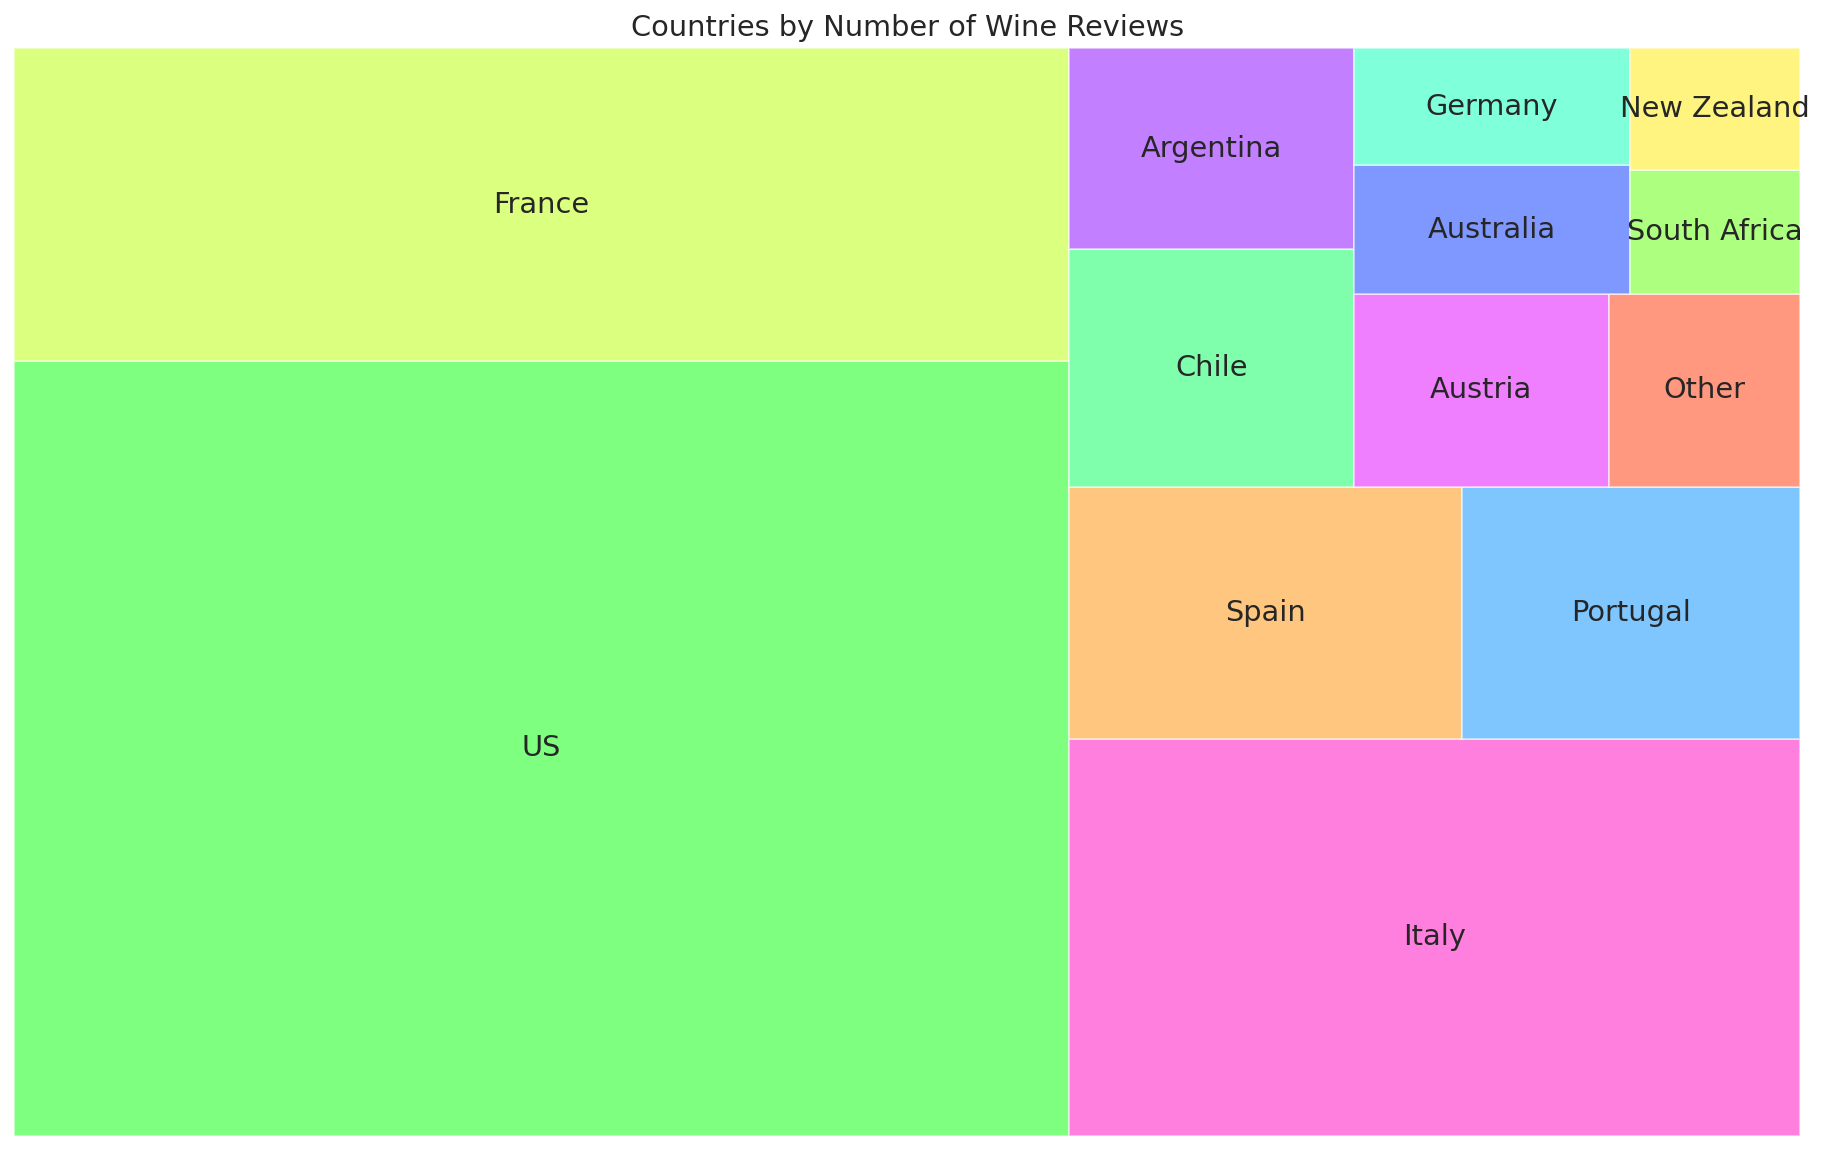

In [15]:
# Tree map 
cmap = plt.cm.gist_rainbow_r
norm = matplotlib.colors.Normalize(vmin=0, vmax=15)
colors = [cmap(norm(value)) for value in range(15)]
np.random.shuffle(colors)
fig,ax = plt.subplots(1,1,figsize=(16, 10))
sq.plot(sizes=less_countries.values, label=less_countries.index.values, alpha=0.5, ax=ax, color=colors)
plt.axis('off')
plt.title('Countries by Number of Wine Reviews')

The highest number of wine reviews is from the US

Price and Points

In [16]:
fig = iplot([go.Scatter(x=df.head(1000)['points'],
                  y=df.head(1000)['price'],
                  mode='markers', marker_color='darkred')])

In [17]:
data = df.assign(n=0).groupby(['points', 'price'])['n'].count().reset_index()
data = data[data["price"] < 100]
v = data.pivot(index='price', columns='points', values='n').fillna(0).values.tolist()
iplot([go.Surface(z=v)])

In [18]:
w = df.groupby(['country','points'])['price'].agg(['count','min','max','mean']).sort_values(by='mean',ascending=False)[:10]
w.reset_index(inplace=True)
w.style.background_gradient(cmap='Wistia', high=0.5)

What we can see is the more points when the wine is more expensive

Variety of wines

Number of variety of wines 707


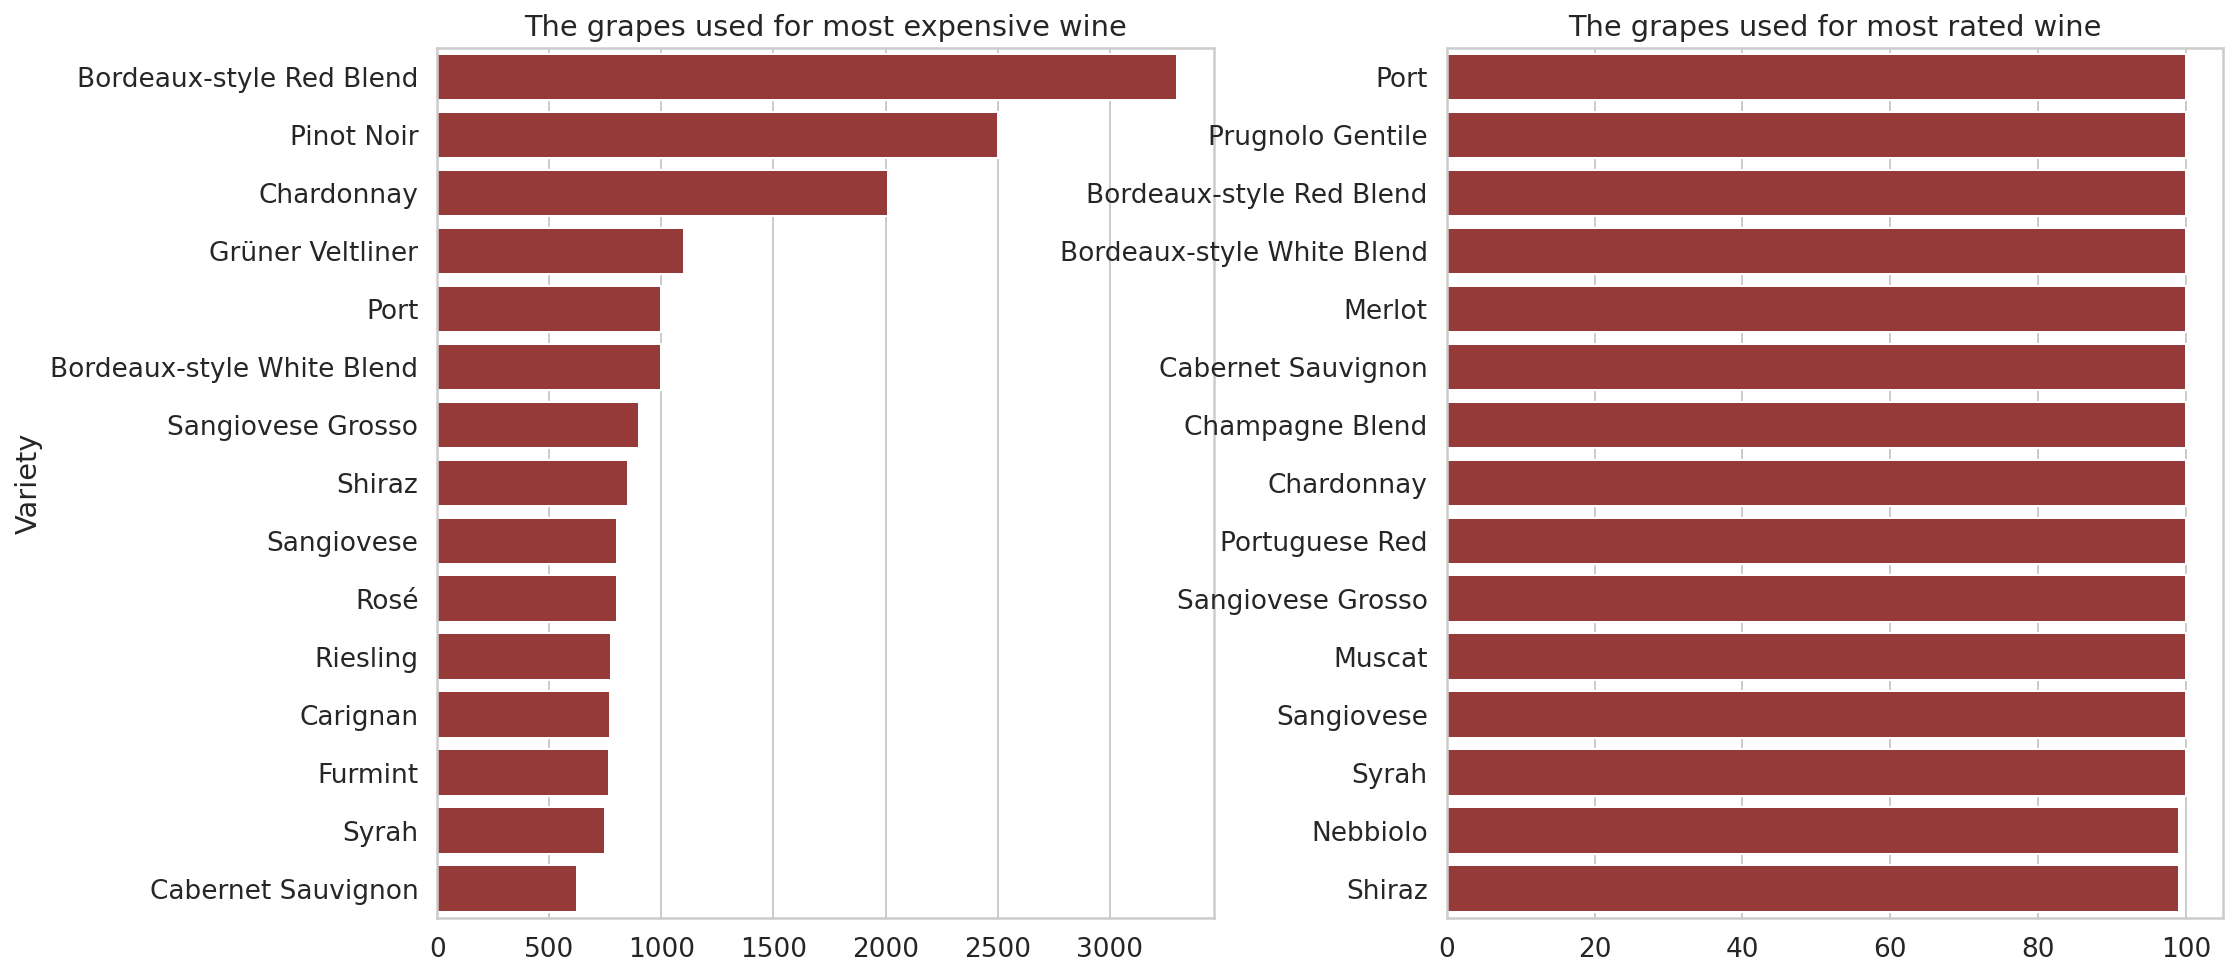

In [19]:
print(Fore.BLACK + 'Number of variety of wines', df['variety'].nunique())
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['variety'])['price'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='brown',ax=ax1)
ax1.set_title('The grapes used for most expensive wine')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['variety'])['points'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='brown',ax=ax2)
ax2.set_title('The grapes used for most rated wine')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

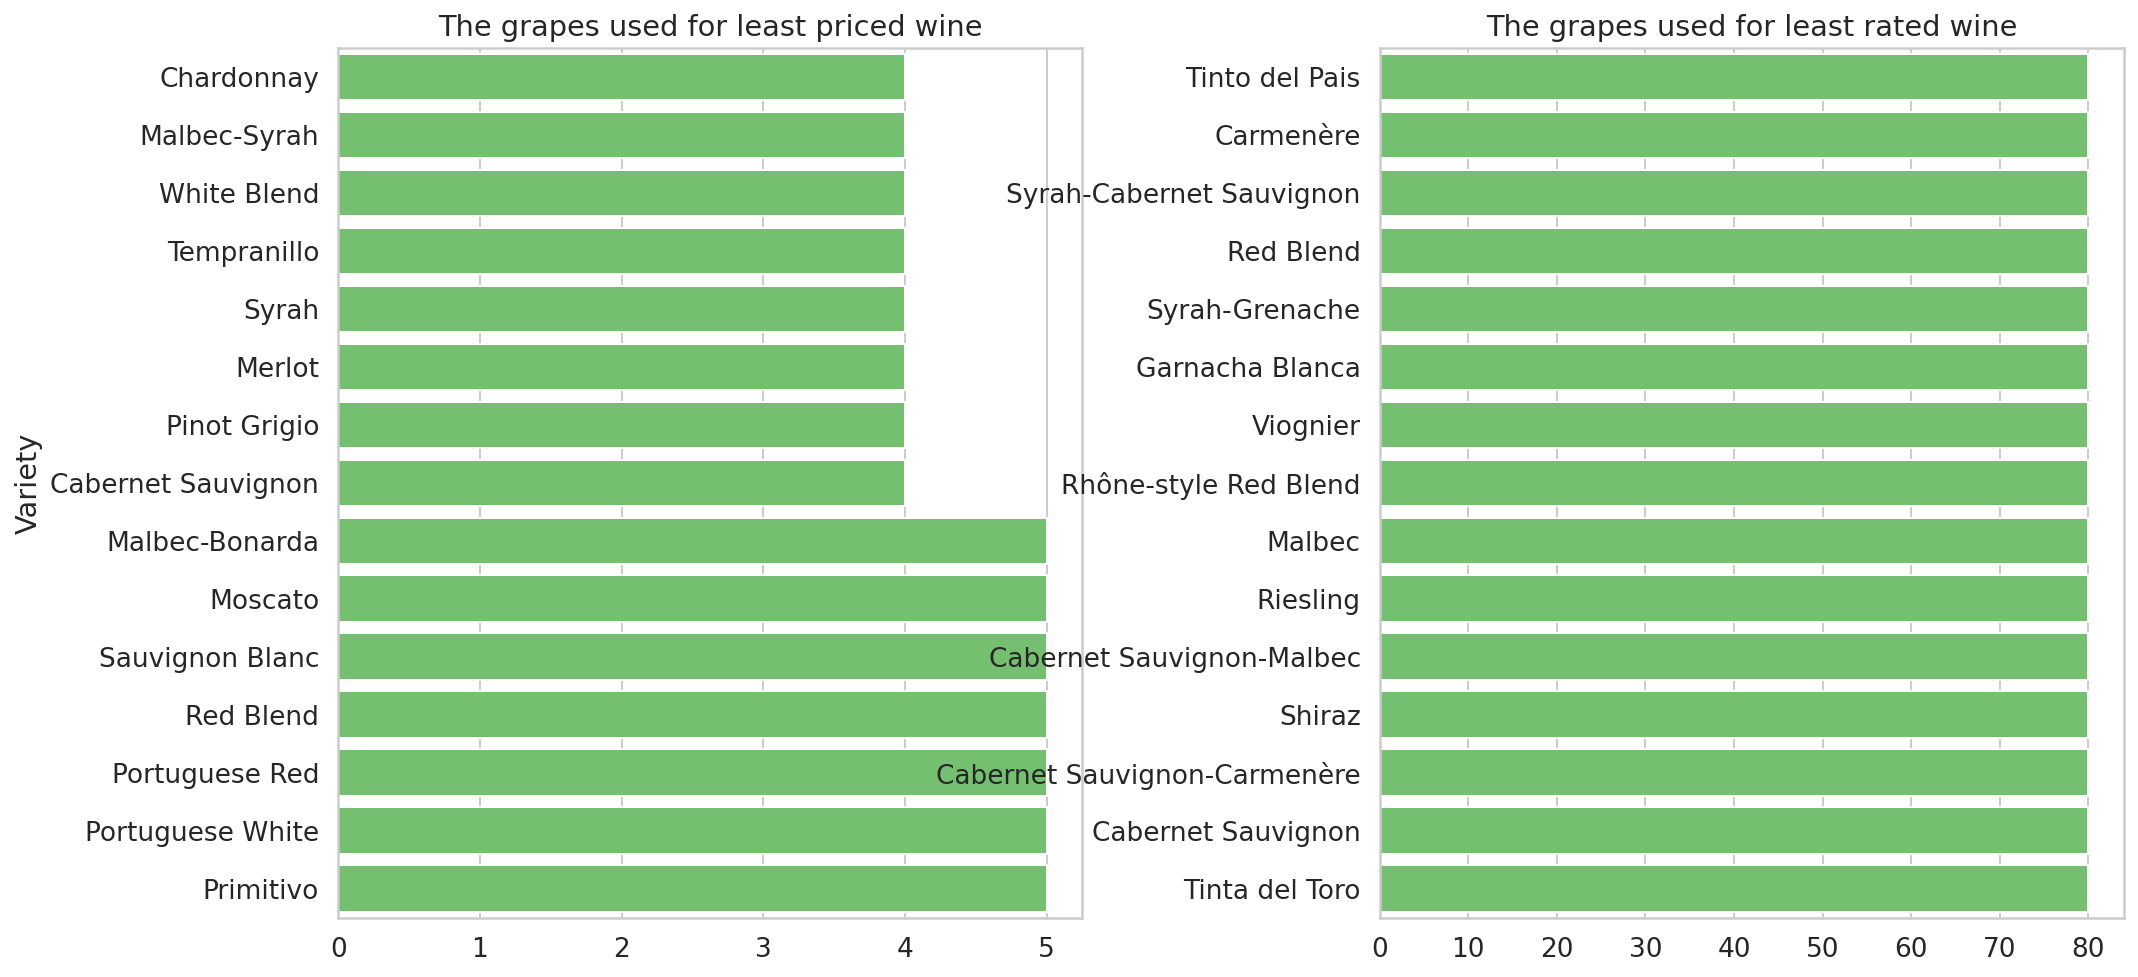

In [20]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['variety'])['price'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='g',ax=ax1)
ax1.set_title('The grapes used for least priced wine')
ax1.set_xlabel('')
ax1.set_ylabel('Variety')
w = df.groupby(['variety'])['points'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='g', ax=ax2)
ax2.set_title('The grapes used for least rated wine')
ax2.set_xlabel('')
ax2.set_ylabel('')
plt.subplots_adjust(wspace=0.4);


Wine price by country

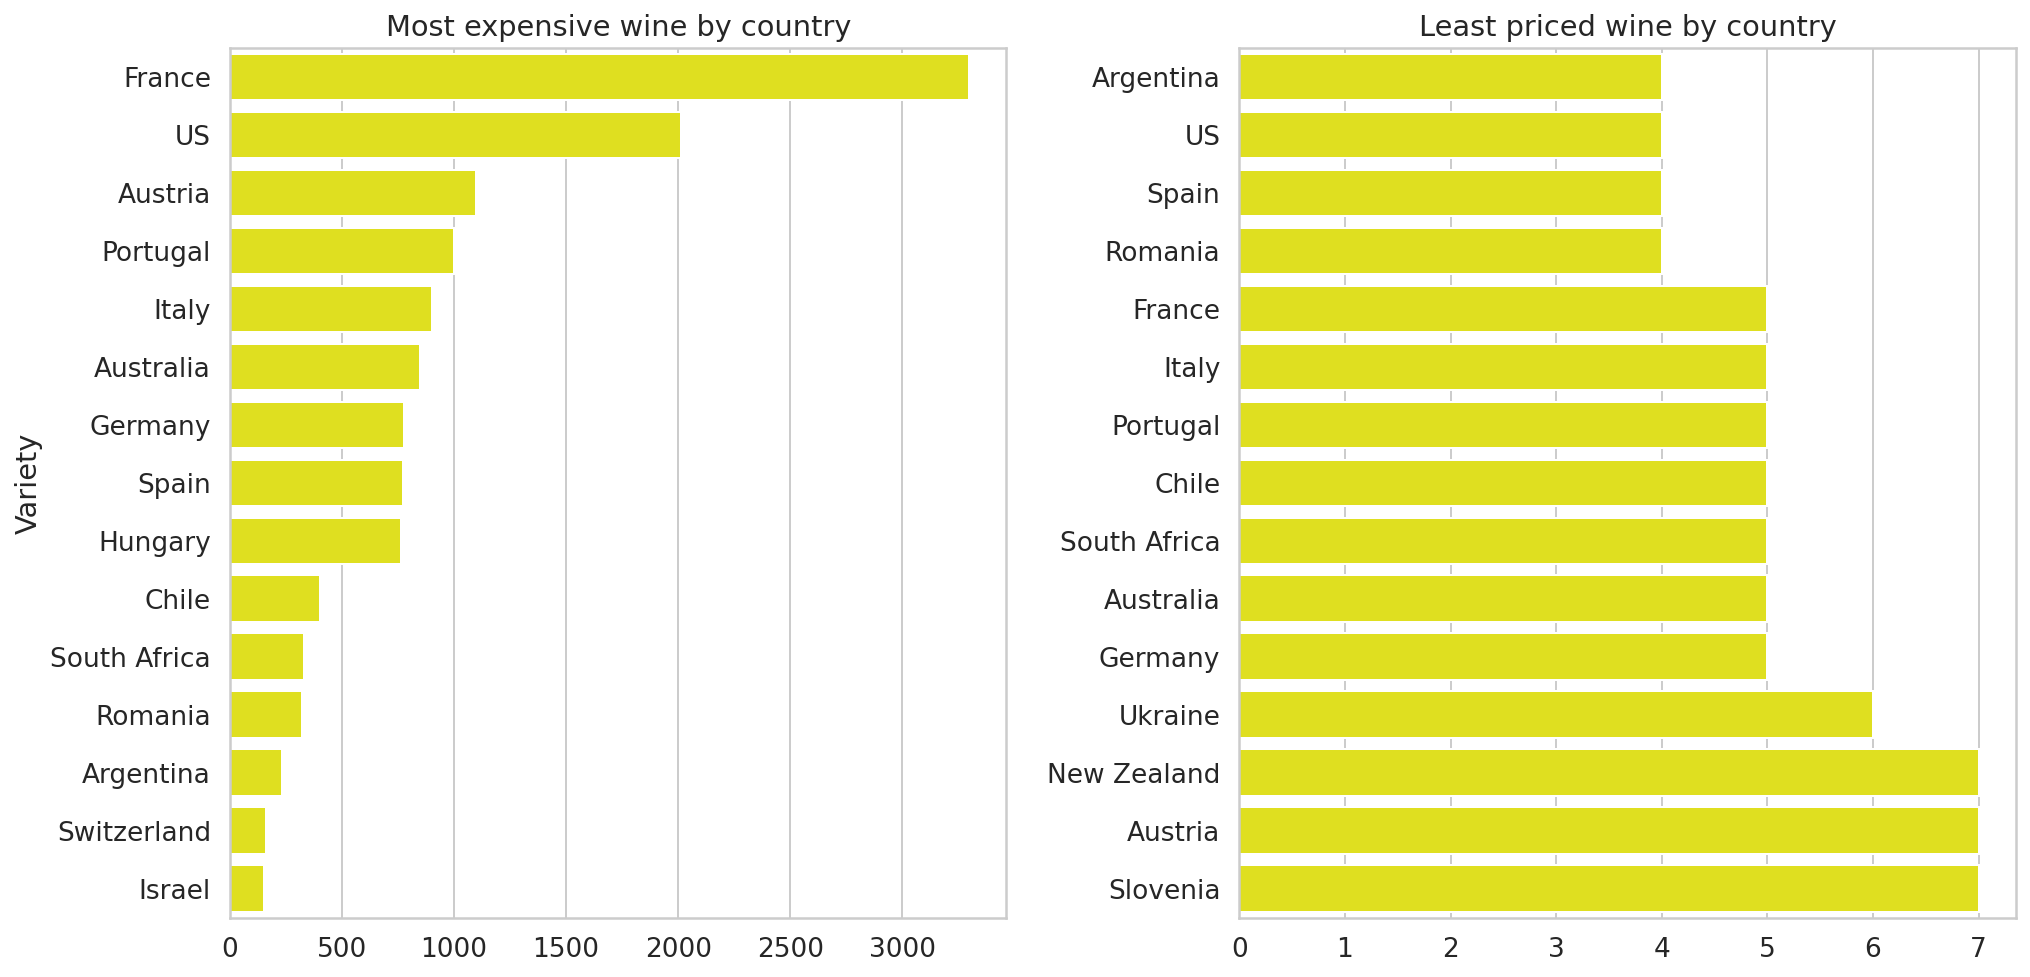

In [21]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['country'])['price'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='yellow',ax=ax1)
ax1.set_title('Most expensive wine by country')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['country'])['price'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index, color='yellow',ax=ax2)
ax2.set_title('Least priced wine by country')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

France generally produces the most expensive wines while Argentina produces the cheapest wines

Highest and least rated wines

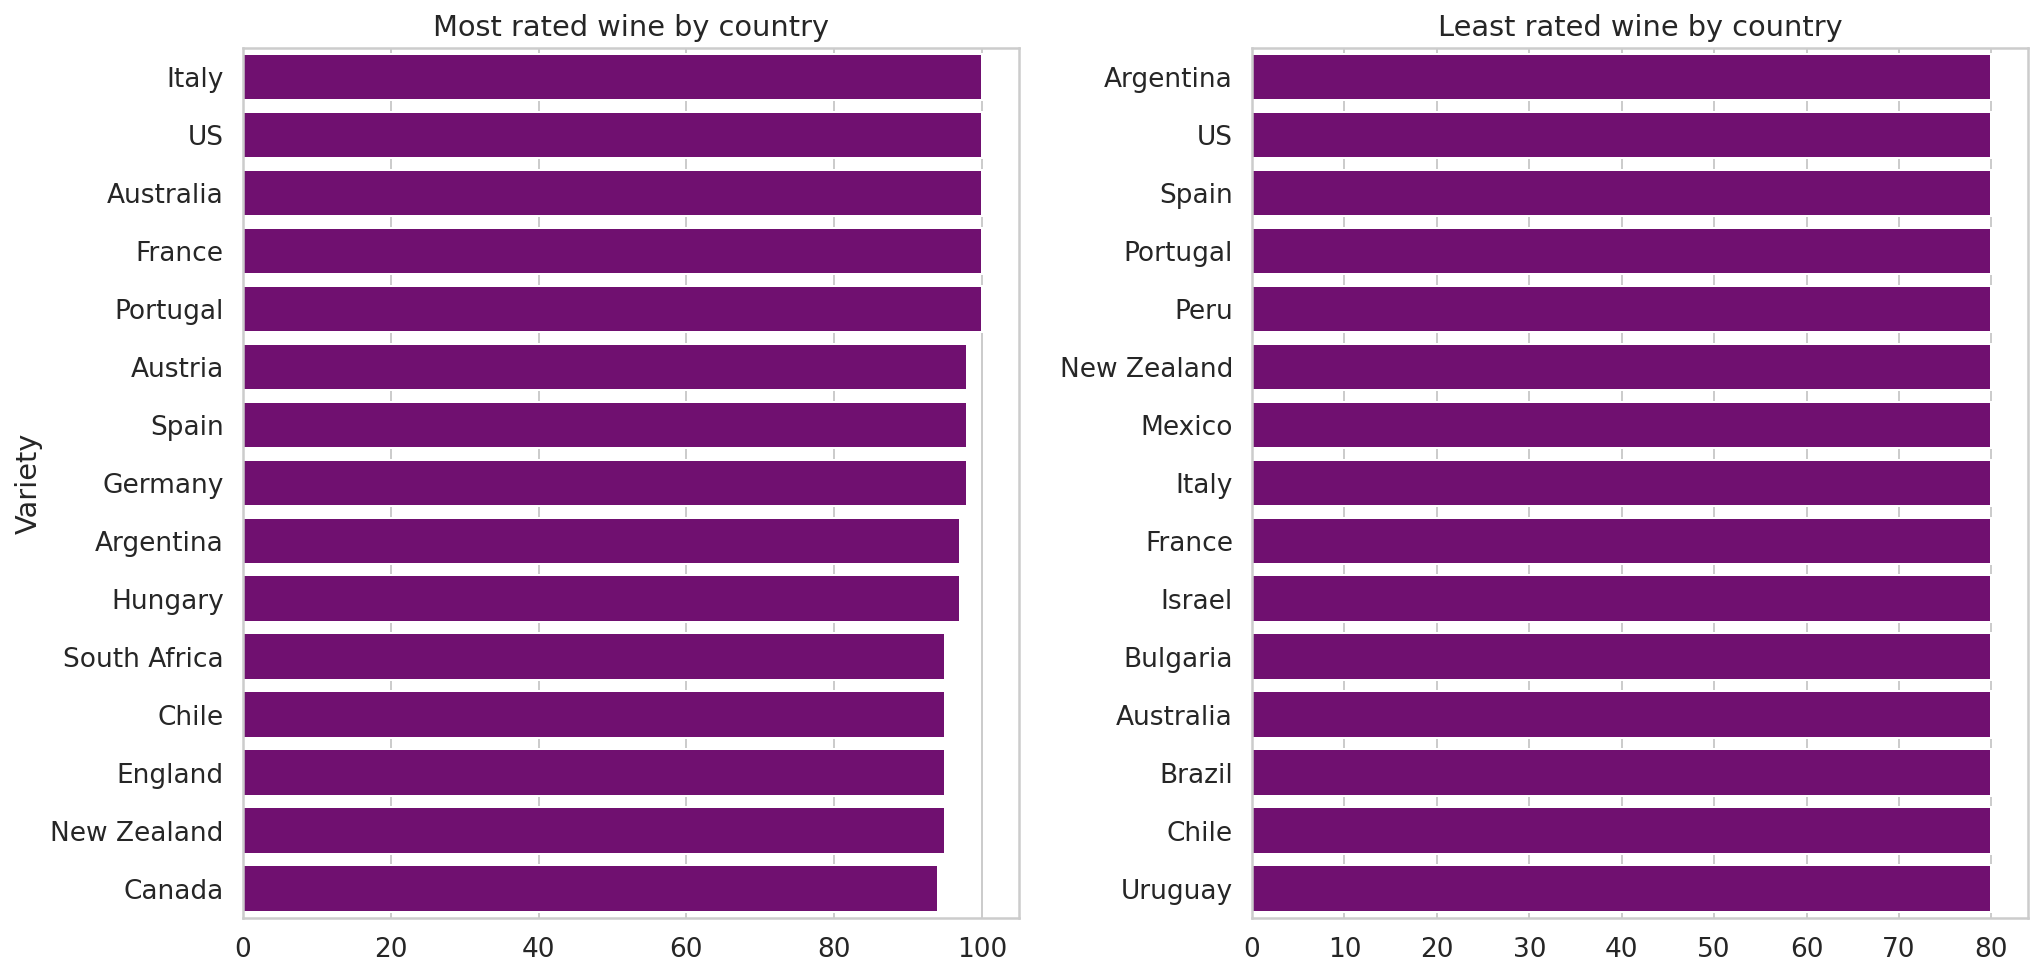

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['country'])['points'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='purple',ax=ax1)
ax1.set_title('Most rated wine by country')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['country'])['points'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, color='purple',ax=ax2)
ax2.set_title('Least rated wine by country')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3);

The highest rated wines are from Italy and the least rated ones are from Argentina

Wine Reviews by Province

Number of province list in data: 425


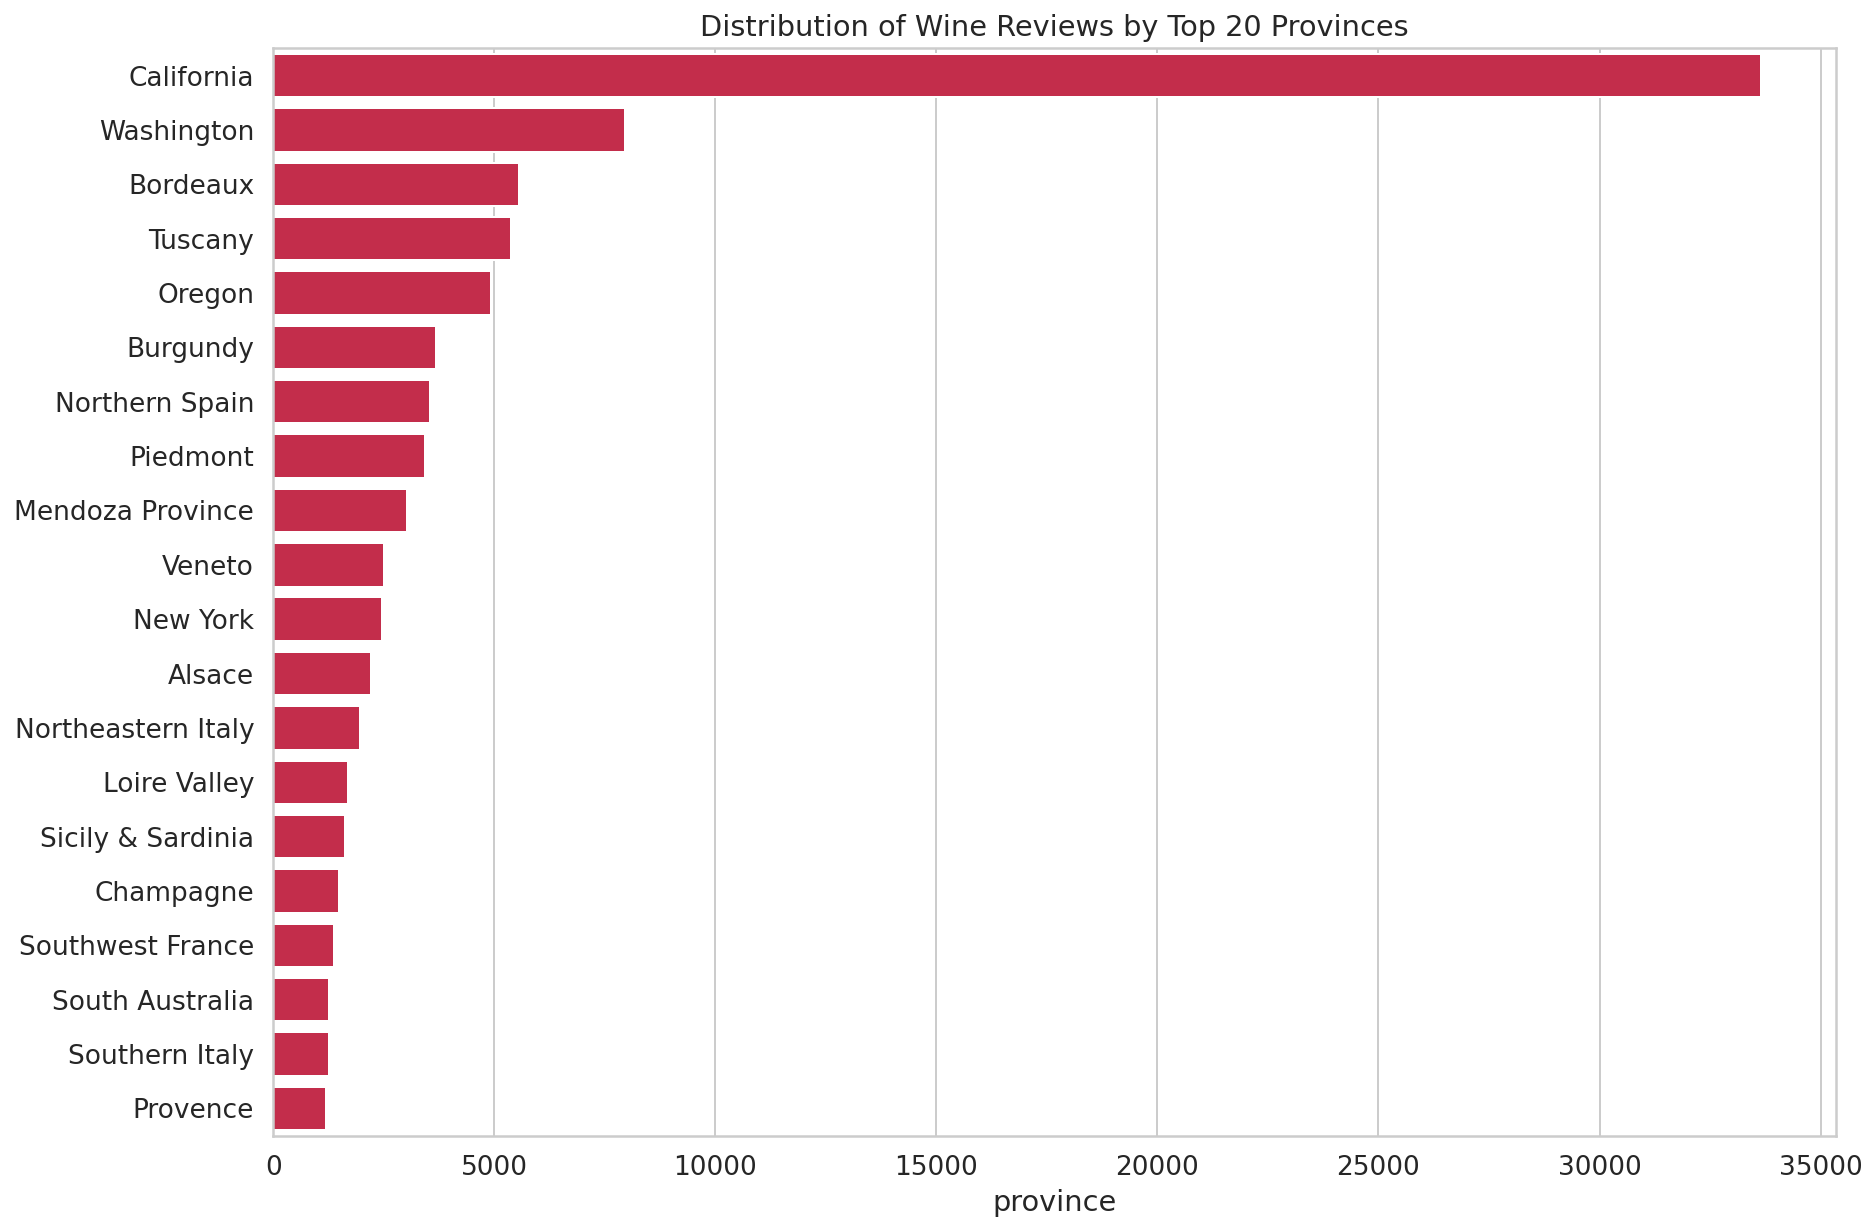

In [23]:
print(Fore.BLUE + Style.BRIGHT + 'Number of province list in data:', df['province'].nunique())
plt.figure(figsize=(14,10))
w = df['province'].value_counts().to_frame()[0:20]
#plt.xscale('log')
sns.barplot(x= w['province'], y =w.index, data=w, color='crimson', orient='h')
plt.title('Distribution of Wine Reviews by Top 20 Provinces');

California has the highest number of wine reviews, followed by Washington state

Vineyards and Wineries

Number of vineyard designation 37980


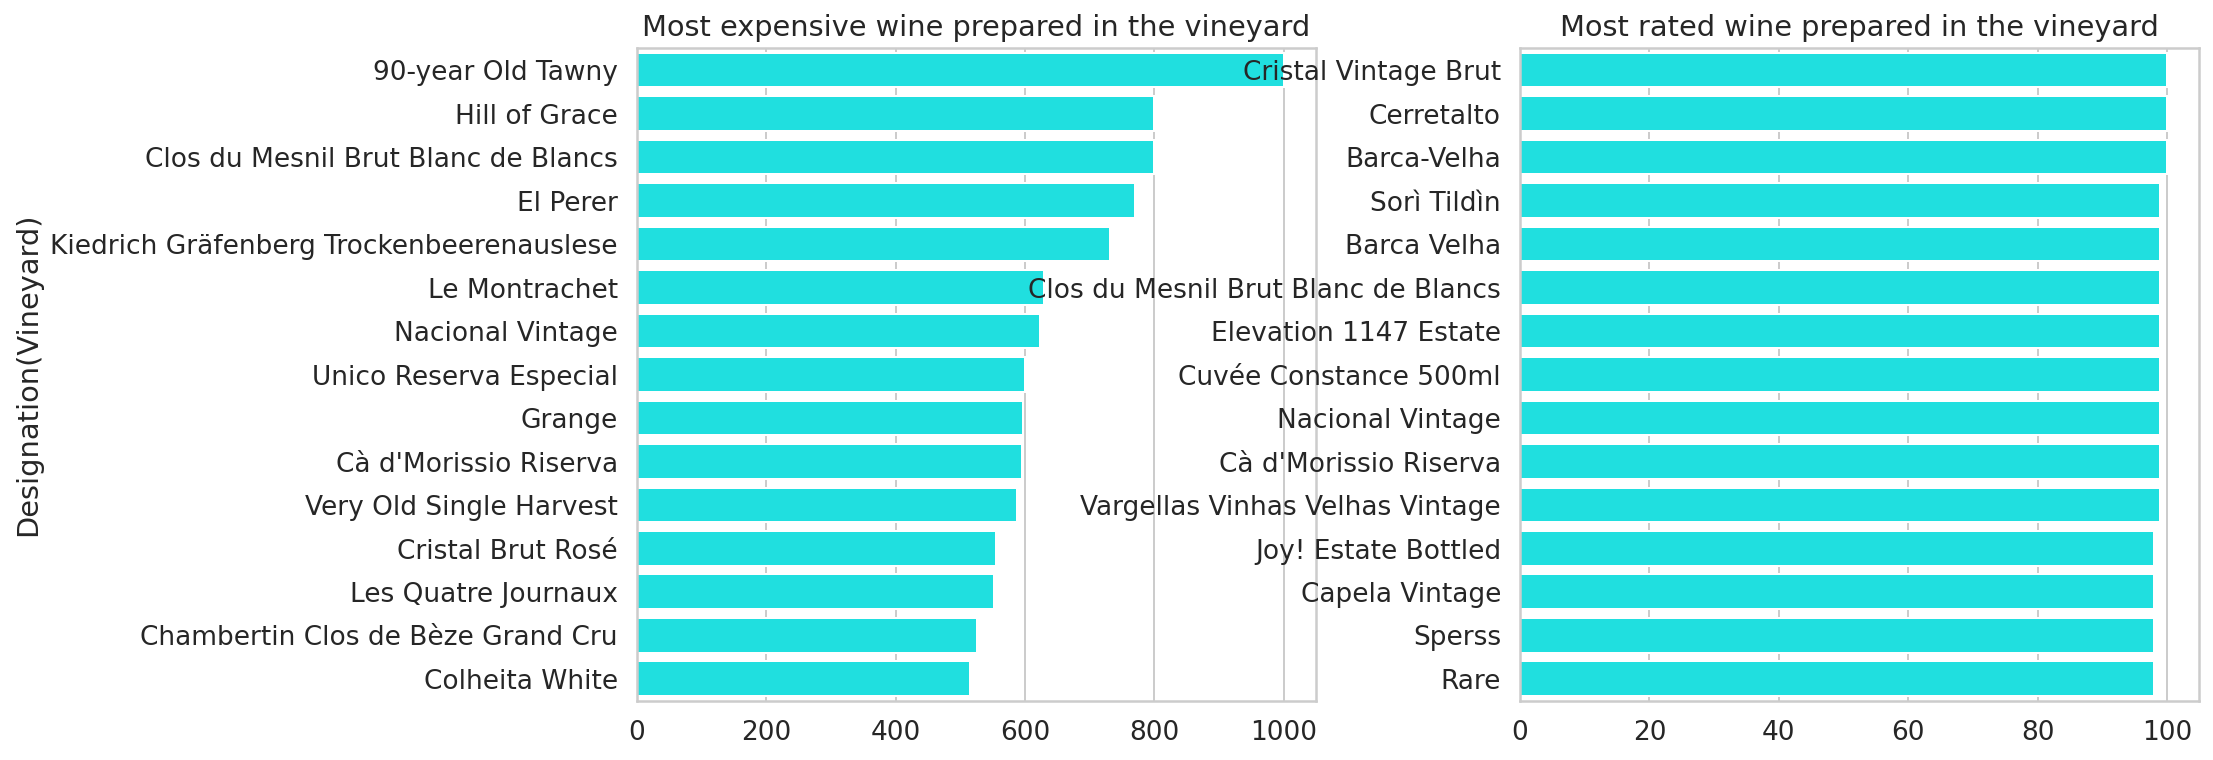

In [24]:
print(Fore.RED + Style.BRIGHT + 'Number of vineyard designation', df['designation'].nunique())
w = df.groupby(['designation'])['price'].mean().to_frame().sort_values(by='price',ascending=False)[:15]
f,ax = plt.subplots(1,2,figsize= (14,6))
ax1,ax2 = ax.flatten()
sns.barplot(w['price'], y = w.index, color='cyan', ax = ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Designation(Vineyard)')
ax1.set_title('Most expensive wine prepared in the vineyard')
w = df.groupby(['designation'])['points'].mean().to_frame().sort_values(by = 'points', ascending = False)[:15]
sns.barplot(w['points'], y = w.index, color='cyan', ax = ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Most rated wine prepared in the vineyard')
plt.subplots_adjust(wspace=0.3)

Number of wineries: 16757


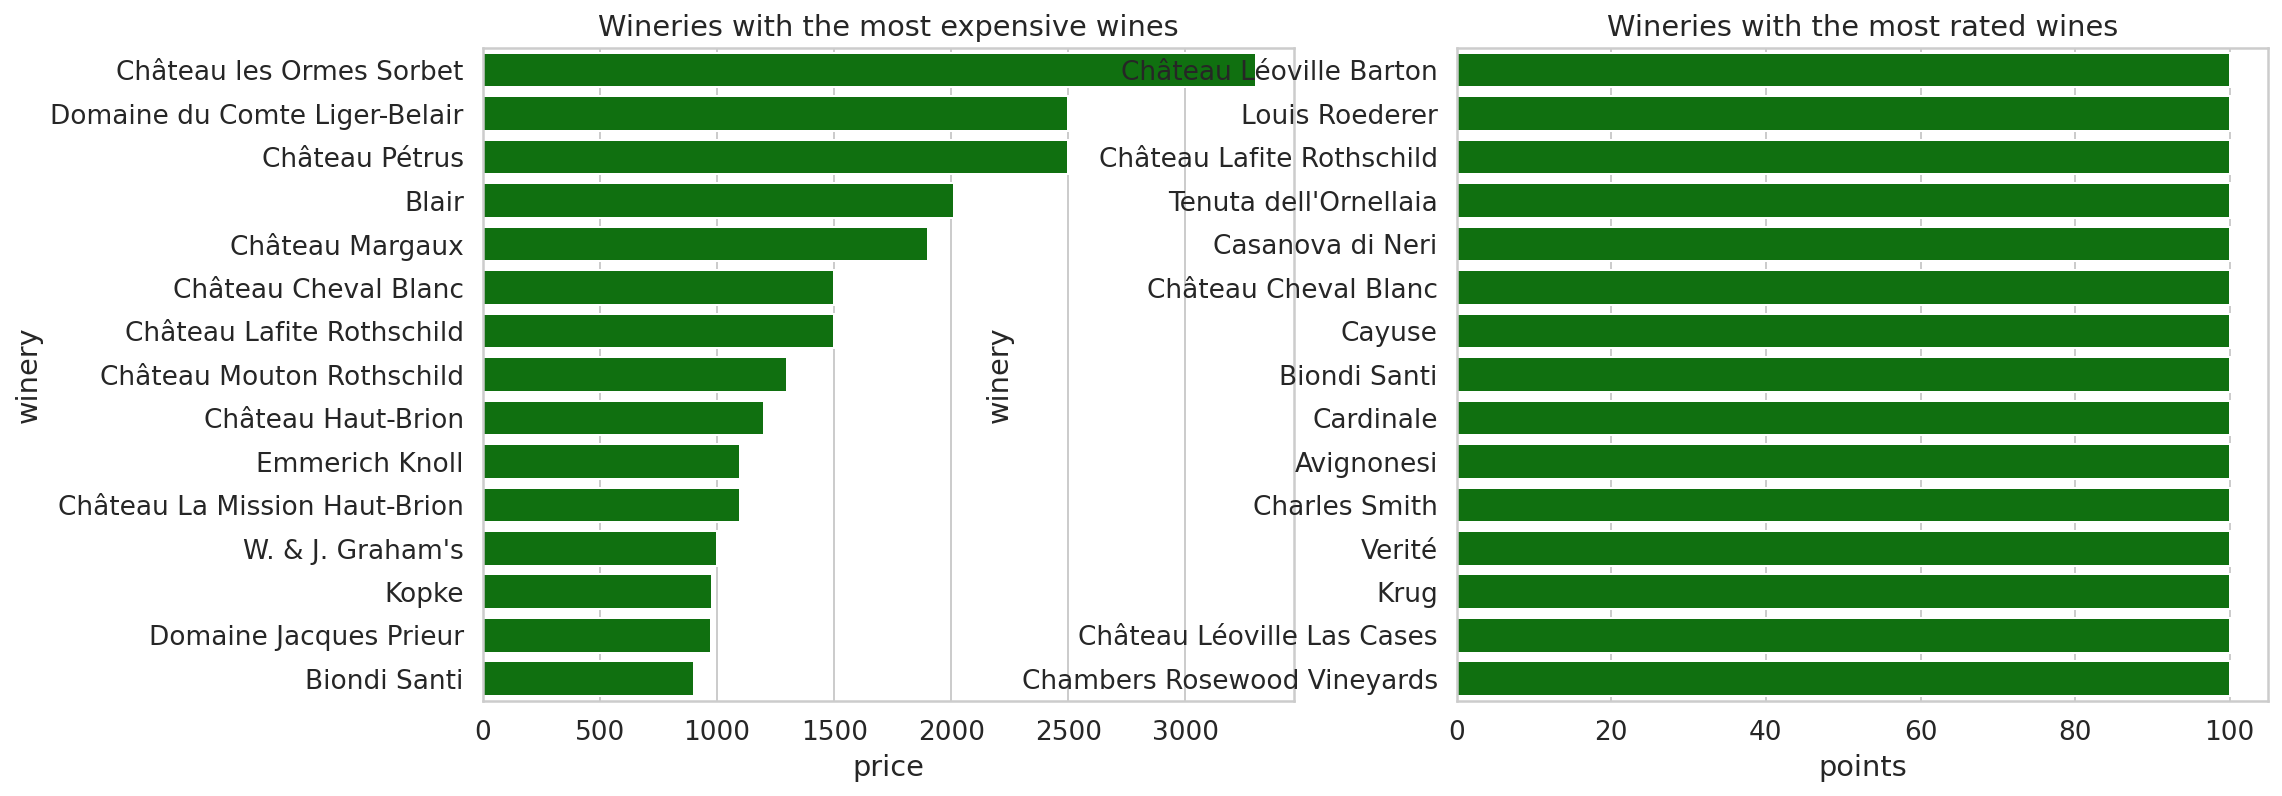

In [25]:
print(Fore.RED + Style.BRIGHT + 'Number of wineries:', df['winery'].nunique())
f,ax = plt.subplots(1,2,figsize=(16,6))
ax1,ax2 = ax.flatten()
w = df.groupby(['winery'])['price'].max().to_frame().sort_values(by='price',ascending=False)[:15]
sns.barplot(w['price'],y = w.index, color='green',ax = ax1)
ax1.set_title('Wineries with the most expensive wines')
w = df.groupby(['winery'])['points'].max().to_frame().sort_values(by = 'points', ascending = False)[:15]
sns.barplot(w['points'], y = w.index, color='green')
plt.title('Wineries with the most rated wines');

Word Clouds

(-0.5, 999.5, 799.5, -0.5)

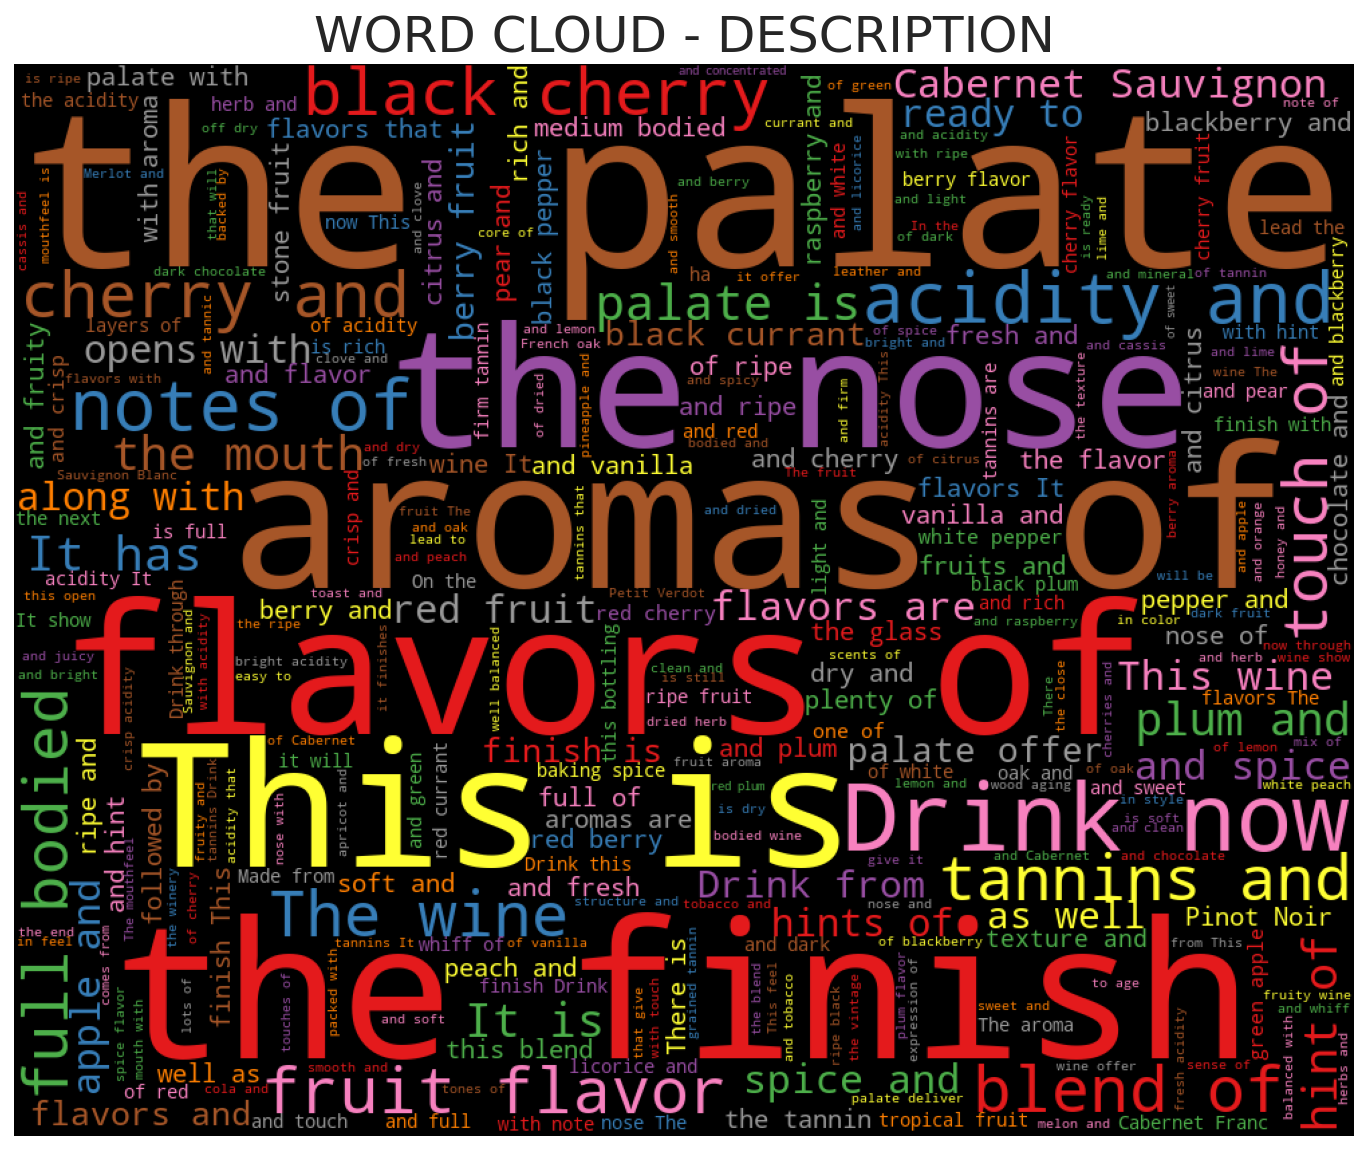

In [26]:
stopwords = set(STOPWORDS)
newStopWords = ['fruit', "Drink", "black", 'wine', 'drink']
stopwords.update(newStopWords)
wordcloud = WordCloud(
    stopwords=stopwords,
    colormap='Set1',
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df['description'].astype(str)))
print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - DESCRIPTION",fontsize=25)
plt.axis('off')

(-0.5, 999.5, 799.5, -0.5)

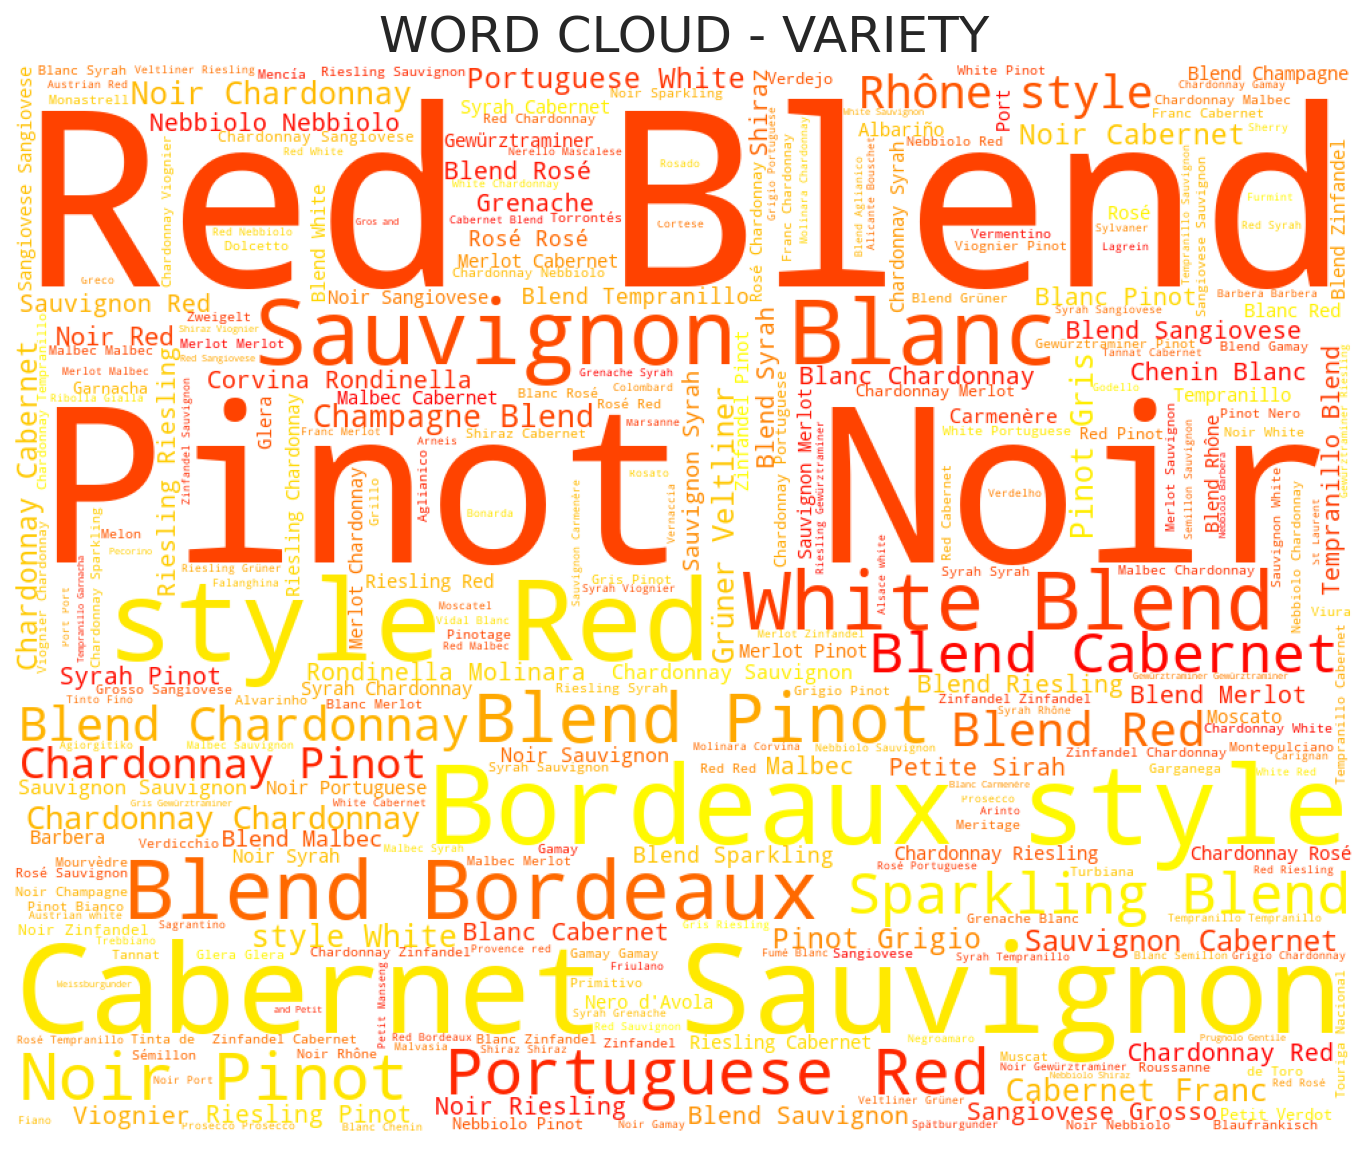

In [27]:
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    colormap='autumn_r',
    max_words=300,
    max_font_size=200, 
    width=1000, height=800,
    random_state=42,
).generate(" ".join(df['variety'].astype(str)))
print(wordcloud)
fig = plt.figure(figsize = (12,14))
plt.imshow(wordcloud)
plt.title("WORD CLOUD - VARIETY",fontsize=25)
plt.axis('off')

In [28]:
# We only require the description and variety of grapes
df = df[['description', 'variety']]
df.head()

description         variety
0  Aromas include tropical fruit, broom, brimston...     White Blend
1  This is ripe and fruity, a wine that is smooth...  Portuguese Red
2  Tart and snappy, the flavors of lime flesh and...      Pinot Gris
3  Pineapple rind, lemon pith and orange blossom ...        Riesling
4  Much like the regular bottling from 2012, this...      Pinot Noir

Duplicate data are already filtered out in the previous section

In [29]:
df.shape

(119988, 2)

In [30]:
# Getting top 7 most described variety
temp_df = df.variety.value_counts()
temp_df.head(7)

Pinot Noir                  12278
Chardonnay                  10868
Cabernet Sauvignon           8840
Red Blend                    8243
Bordeaux-style Red Blend     6471
Riesling                     4773
Sauvignon Blanc              4575
Name: variety, dtype: int64

In [31]:
# For this project we are taking top 7 variety only
mask = df['variety'].isin(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc'])
df = df[mask]
df.head()

description             variety
3   Pineapple rind, lemon pith and orange blossom ...            Riesling
4   Much like the regular bottling from 2012, this...          Pinot Noir
10  Soft, supple plum envelopes an oaky structure ...  Cabernet Sauvignon
12  Slightly reduced, this wine offers a chalky, t...  Cabernet Sauvignon
14  Building on 150 years and six generations of w...          Chardonnay

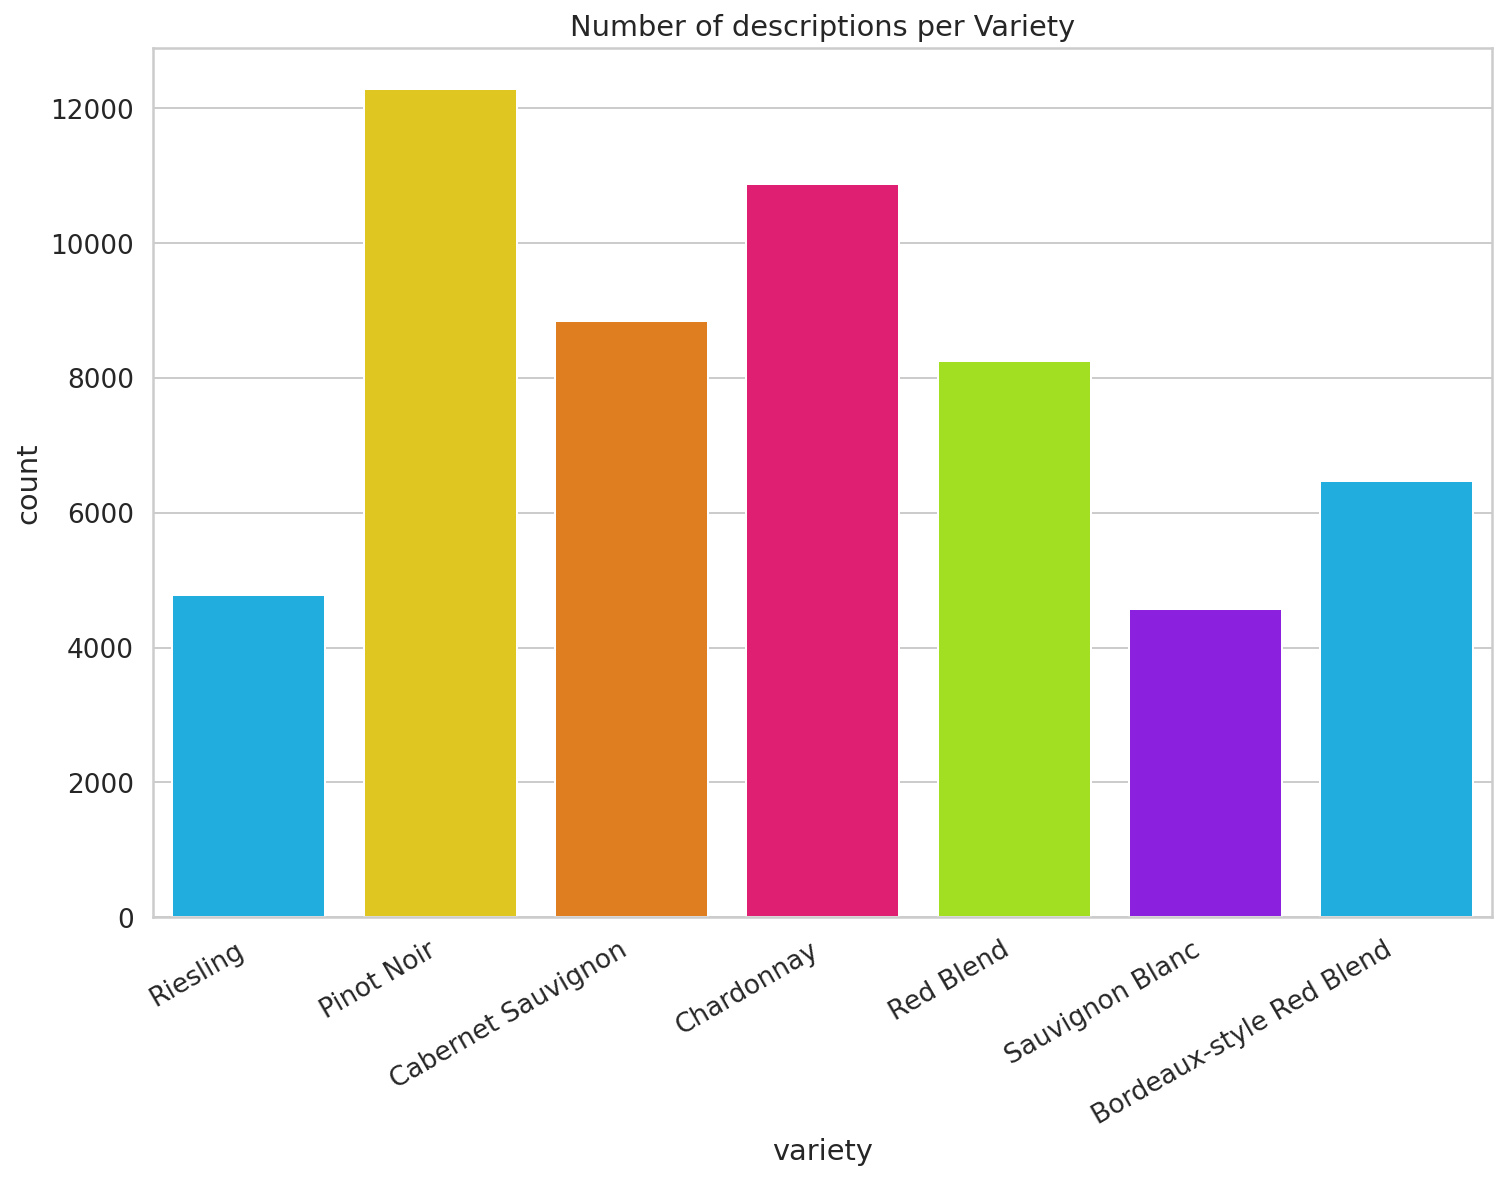

In [32]:
chart = sns.countplot(df.variety, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of descriptions per Variety")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [33]:
# Splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.description, df.variety, test_size = 0.2, random_state = 42)

In [34]:
train = { 'text': X_train, 'intent': y_train }
train_df = pd.DataFrame(train)
test = { 'text': X_test, 'intent': y_test }
test_df = pd.DataFrame(test)

In [35]:
train_df.head()

text  \
84917   A fine example of Lake County Sauvignon Blanc,...   
115838  Aromas of wild herbs, dry brush, rubber, oak a...   
88728   Simple and straightforward, this provides arom...   
69971   Ripe fruit suggests a wine that is soft, juicy...   
74000   Densely fruity wine, all sweetness and richnes...   

                          intent  
84917            Sauvignon Blanc  
115838                 Red Blend  
88728                 Chardonnay  
69971   Bordeaux-style Red Blend  
74000   Bordeaux-style Red Blend

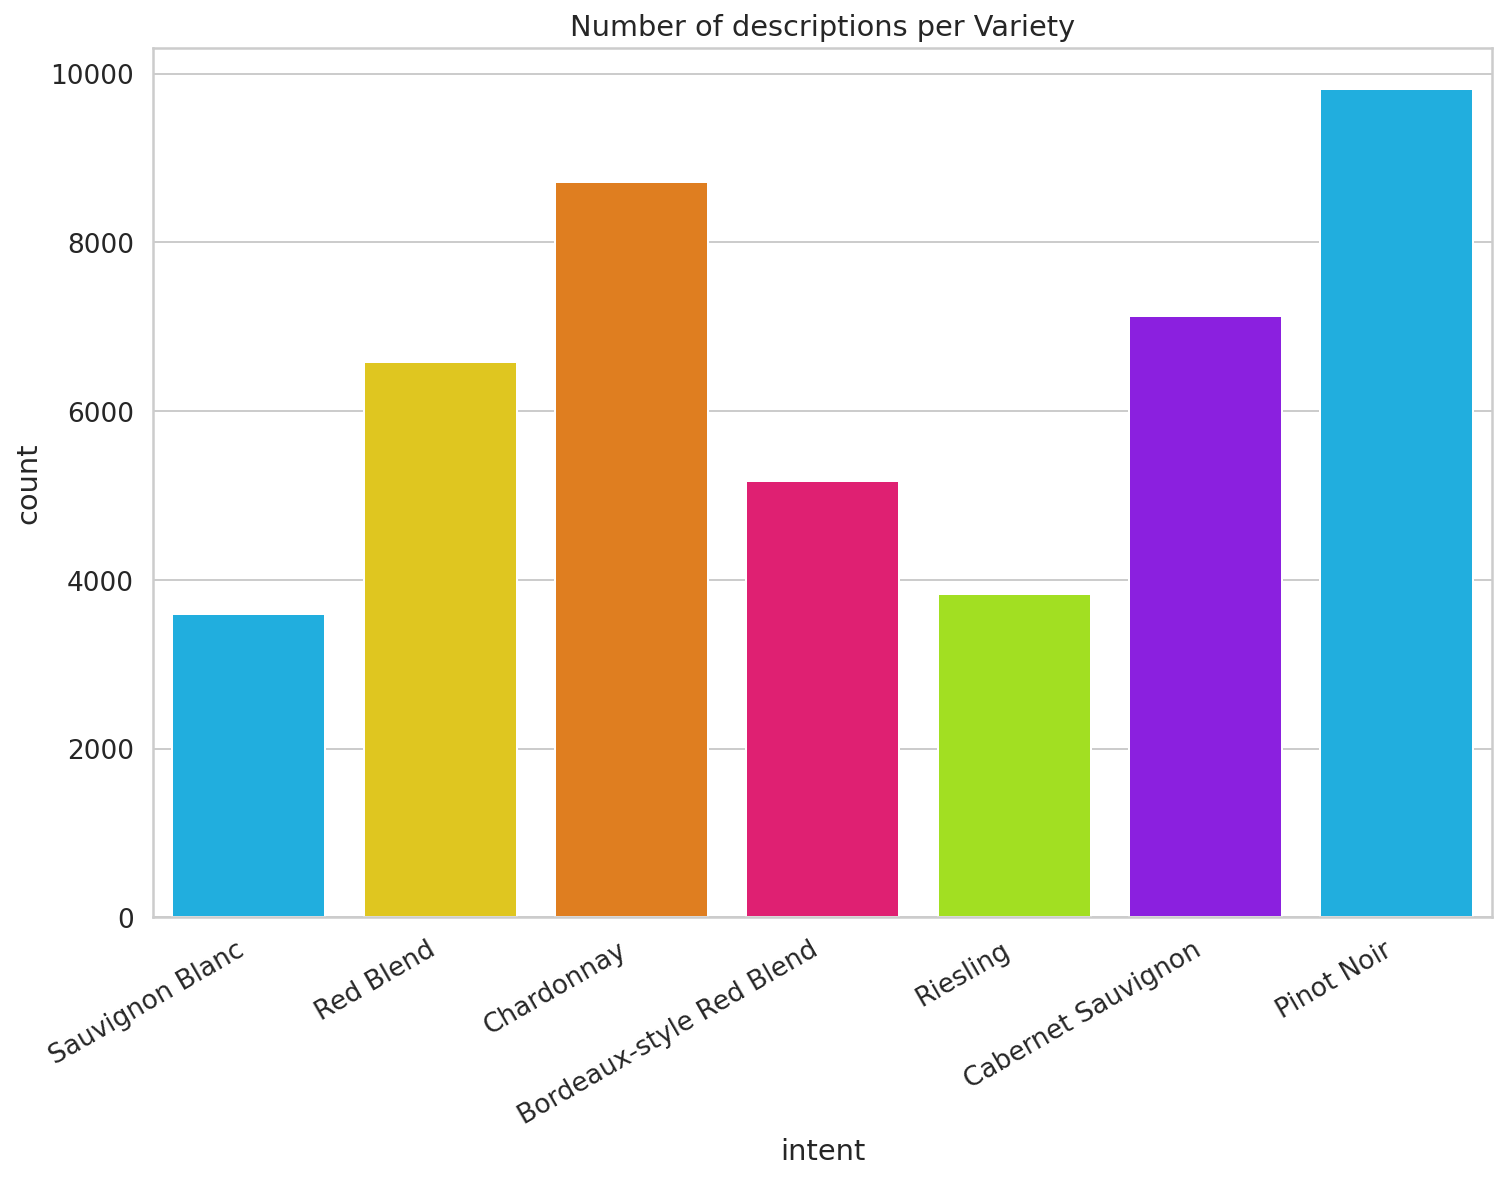

In [36]:
chart = sns.countplot(train_df.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of descriptions per Variety")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Making the training dataset uniform

In [37]:
# Now to make the training dataset uniform, I have taken the wine with least number of count (i.e. Sauvignin Blanc)
sauvignon_blanc_df = train_df[train_df['intent']=='Sauvignon Blanc']

# For doing so, first I have selected other varities of wines
riesling_df = train_df[train_df['intent']=='Riesling']
pinot_noir_df = train_df[train_df['intent']=='Pinot Noir']
chardonnay_df = train_df[train_df['intent']=='Chardonnay']
cabernet_sauvignon_df = train_df[train_df['intent']=='Cabernet Sauvignon']
red_blend_df = train_df[train_df['intent']=='Red Blend']
bordeaux_style_red_blend_df = train_df[train_df['intent']=='Bordeaux-style Red Blend']

In [38]:
# Now I have set their count equal to that of Sauvignin Blanc
pinot_noir_df = pinot_noir_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
chardonnay_df = chardonnay_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
cabernet_sauvignon_df = cabernet_sauvignon_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
red_blend_df = red_blend_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
bordeaux_style_red_blend_df = bordeaux_style_red_blend_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)
riesling_df = riesling_df.sample(n=len(sauvignon_blanc_df), random_state=RANDOM_SEED)

In [39]:
# Now I am adding all the data together
sauvignon_blanc_df = sauvignon_blanc_df.append(pinot_noir_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(chardonnay_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(cabernet_sauvignon_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(red_blend_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(bordeaux_style_red_blend_df).reset_index(drop=True)
sauvignon_blanc_df = sauvignon_blanc_df.append(riesling_df).reset_index(drop=True)
train_df = sauvignon_blanc_df
train_df.shape

(25200, 2)

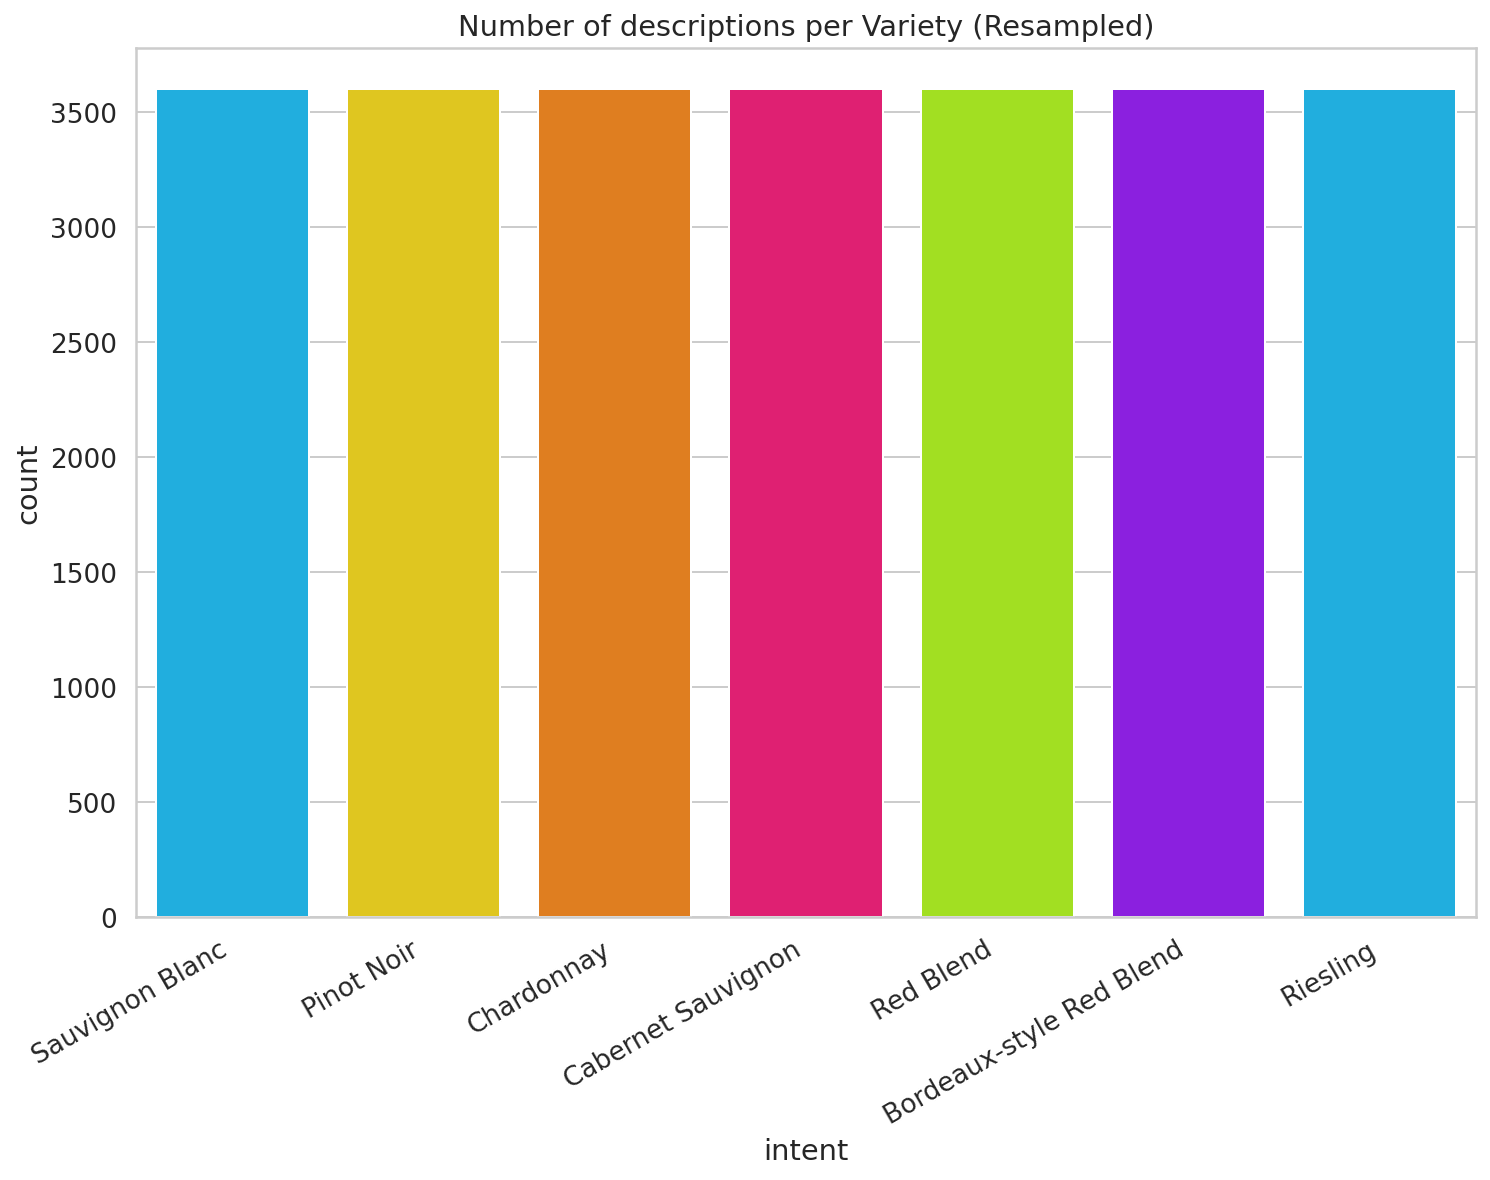

In [40]:
chart = sns.countplot(train_df.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of descriptions per Variety (Resampled)")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [41]:
# Here I am shuffling the data
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [42]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2023-05-13 01:50:47--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  39.2MB/s    in 10s     

2023-05-13 01:50:58 (37.3 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [43]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [44]:
os.makedirs("model", exist_ok=True)

In [45]:
!mv uncased_L-12_H-768_A-12/ model

In [46]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

# Final Preprocessing

In [47]:
class IntentDetectionData:
    DATA_COLUMN = "text"
    LABEL_COLUMN = "intent"

    def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
        self.tokenizer = tokenizer
        self.max_seq_len = 0
        self.classes = classes

        train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])

        ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

        print("max seq_len", self.max_seq_len)
        self.max_seq_len = min(self.max_seq_len, max_seq_len)
        self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

    def _prepare(self, df):
        x, y = [], []

        for _, row in tqdm(df.iterrows()):
            text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
            tokens = self.tokenizer.tokenize(text)
            tokens = ["[CLS]"] + tokens + ["[SEP]"]
            token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            self.max_seq_len = max(self.max_seq_len, len(token_ids))
            x.append(token_ids)
            y.append(self.classes.index(label))

        return np.array(x), np.array(y)

    def _pad(self, ids):
        x = []
        for input_ids in ids:
            input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
            input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
            x.append(np.array(input_ids))
        return np.array(x)

In [48]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [49]:
tokenizer.tokenize("I like french classic wine")

['i', 'like', 'french', 'classic', 'wine']

In [50]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [51]:
def create_model(max_seq_len, bert_ckpt_file):

    with tf.io.gfile.GFile(bert_config_file, "r") as reader:
        bc = StockBertConfig.from_json_string(reader.read())
        bert_params = map_stock_config_to_params(bc)
        bert_params.adapter_size = None
        bert = BertModelLayer.from_params(bert_params, name="bert")

    input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
    bert_output = bert(input_ids)

    print("bert shape", bert_output.shape)

    cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
    cls_out = keras.layers.Dropout(0.5)(cls_out)
    logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
    logits = keras.layers.Dropout(0.5)(logits)
    logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

    model = keras.Model(inputs=input_ids, outputs=logits)
    model.build(input_shape=(None, max_seq_len))

    load_stock_weights(bert, bert_ckpt_file)

    return model

In [52]:
test_df.head()

text  \
42351   This savory blend of 40% Merlot, 30% Cabernet ...   
5914    This is a good value, offering plenty of the p...   
37125   This wine comes from some of the oldest vines ...   
117968  Made in a more reductive style, this bottling ...   
78342   Classically structured, which means dry tannin...   

                          intent  
42351                  Red Blend  
5914             Sauvignon Blanc  
37125                 Chardonnay  
117968                Chardonnay  
78342   Bordeaux-style Red Blend

In [53]:
classes = train_df.intent.unique().tolist()

data = IntentDetectionData(train_df, test_df, tokenizer, classes, max_seq_len=128)

25200it [00:38, 647.74it/s]
11210it [00:17, 653.76it/s]


max seq_len 194


In [54]:
data.train_x.shape

(25200, 128)

In [55]:
data.train_x[0]

array([  101, 10964,  2011, 12849, 23544,  1012,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [56]:
data.train_y[0]

2

In [57]:
data.max_seq_len

128

In [58]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5f96e68b90> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [59]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

# Compiling and Training the model

In [60]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [61]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
1418/1418 [==============================] - 903s 637ms/step - loss: 1.5679 - acc: 0.5963 - val_loss: 1.4069 - val_acc: 0.7599
Epoch 2/5
1418/1418 [==============================] - 907s 639ms/step - loss: 1.3765 - acc: 0.7890 - val_loss: 1.3335 - val_acc: 0.8313
Epoch 3/5
1418/1418 [==============================] - 914s 644ms/step - loss: 1.3415 - acc: 0.8239 - val_loss: 1.3404 - val_acc: 0.8242
Epoch 4/5
1418/1418 [==============================] - 918s 648ms/step - loss: 1.3281 - acc: 0.8362 - val_loss: 1.3208 - val_acc: 0.8440
Epoch 5/5
1418/1418 [==============================] - 924s 652ms/step - loss: 1.3157 - acc: 0.8485 - val_loss: 1.3203 - val_acc: 0.8444


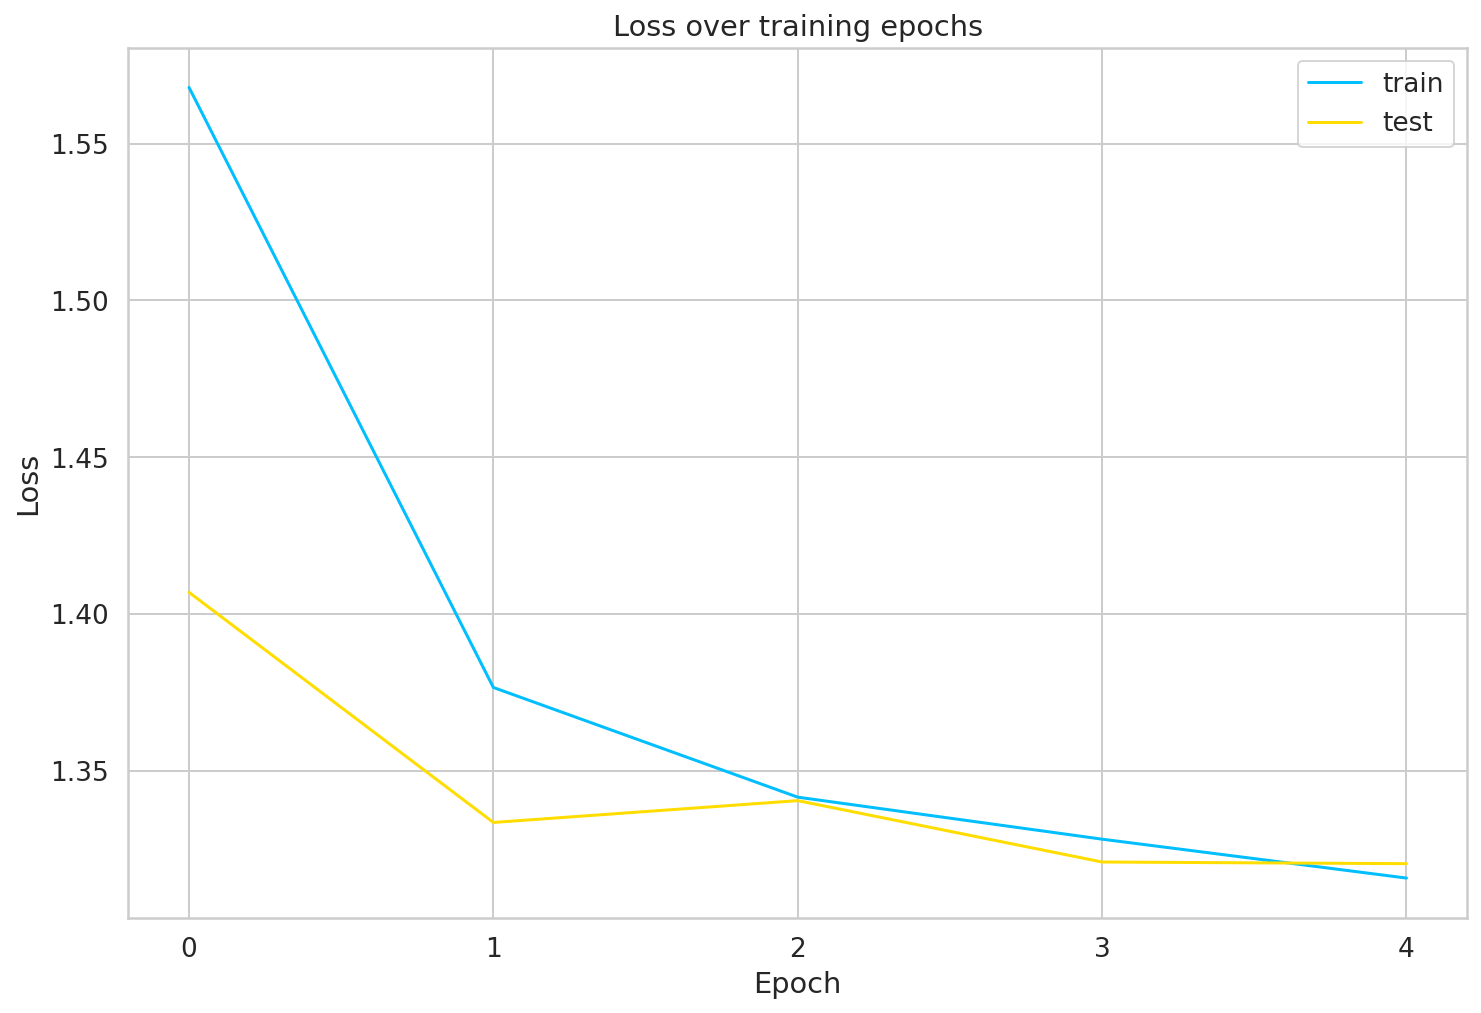

In [62]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

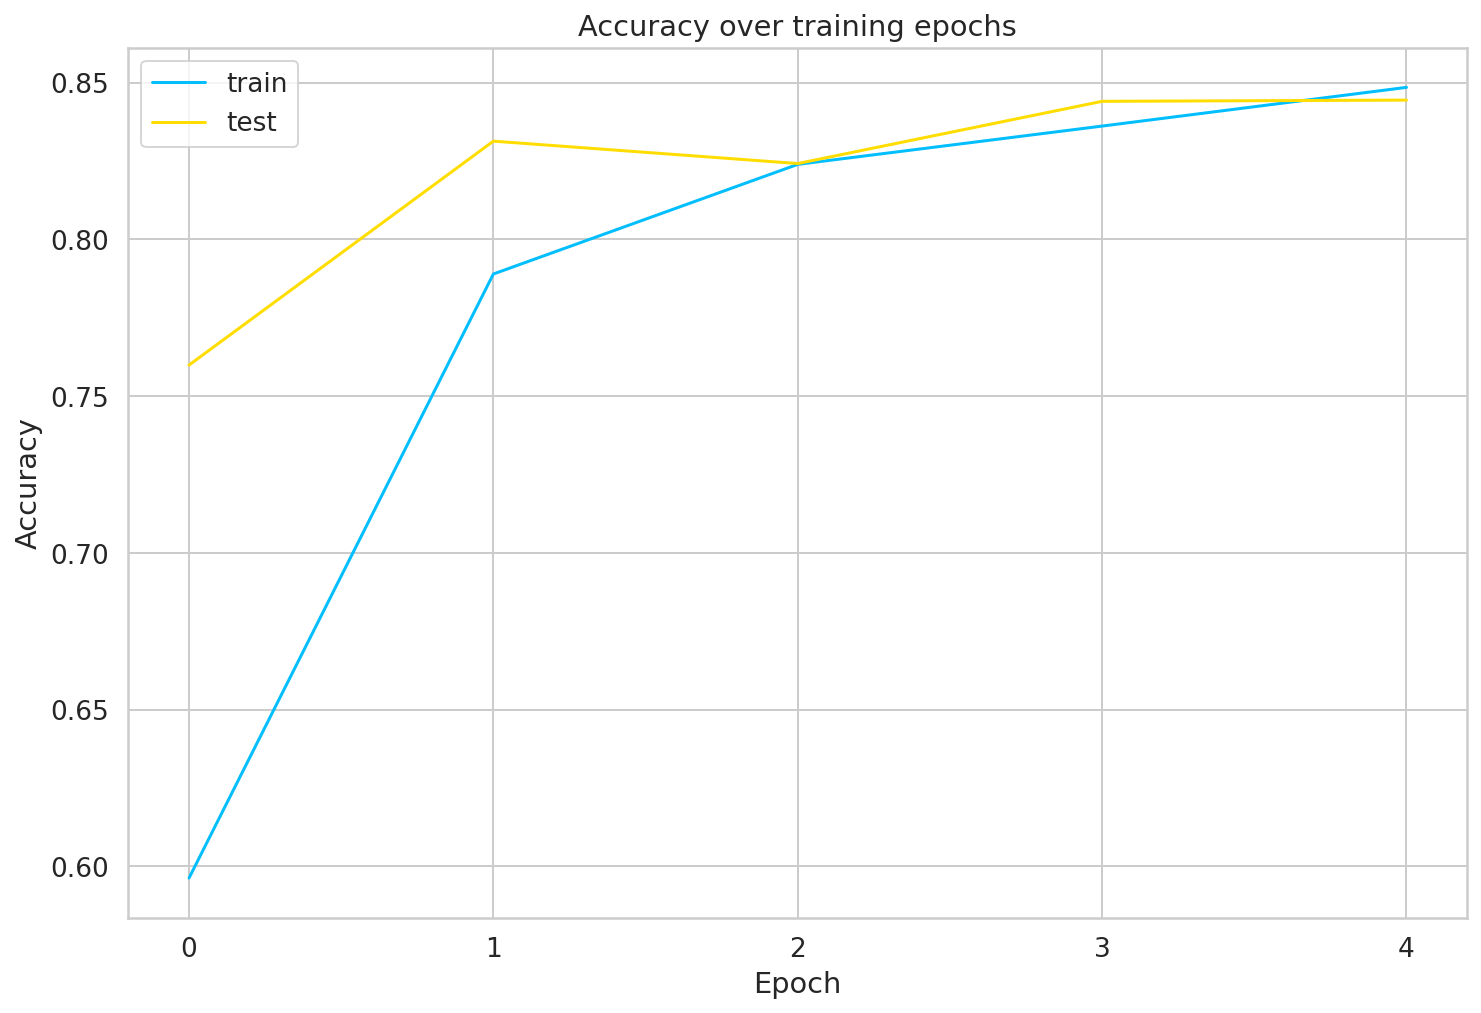

In [63]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [64]:
#Training and Testing accuracy
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

351/351 [==============================] - 61s 175ms/step - loss: 1.3339 - acc: 0.8311
train acc 0.86900794506073
test acc 0.8311328887939453


In [65]:
#Classification Report
y_pred = model.predict(data.test_x).argmax(axis=-1)
print(classification_report(data.test_y, y_pred, target_names=classes))

                          precision    recall  f1-score   support

              Pinot Noir       0.81      0.86      0.83      2461
               Red Blend       0.92      0.74      0.82      1661
              Chardonnay       0.90      0.86      0.88      2155
      Cabernet Sauvignon       0.80      0.79      0.79      1717
                Riesling       0.89      0.87      0.88       941
         Sauvignon Blanc       0.76      0.83      0.80       975
Bordeaux-style Red Blend       0.75      0.89      0.81      1300

                accuracy                           0.83     11210
               macro avg       0.83      0.83      0.83     11210
            weighted avg       0.84      0.83      0.83     11210



In [66]:
#Confusion Matrix
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

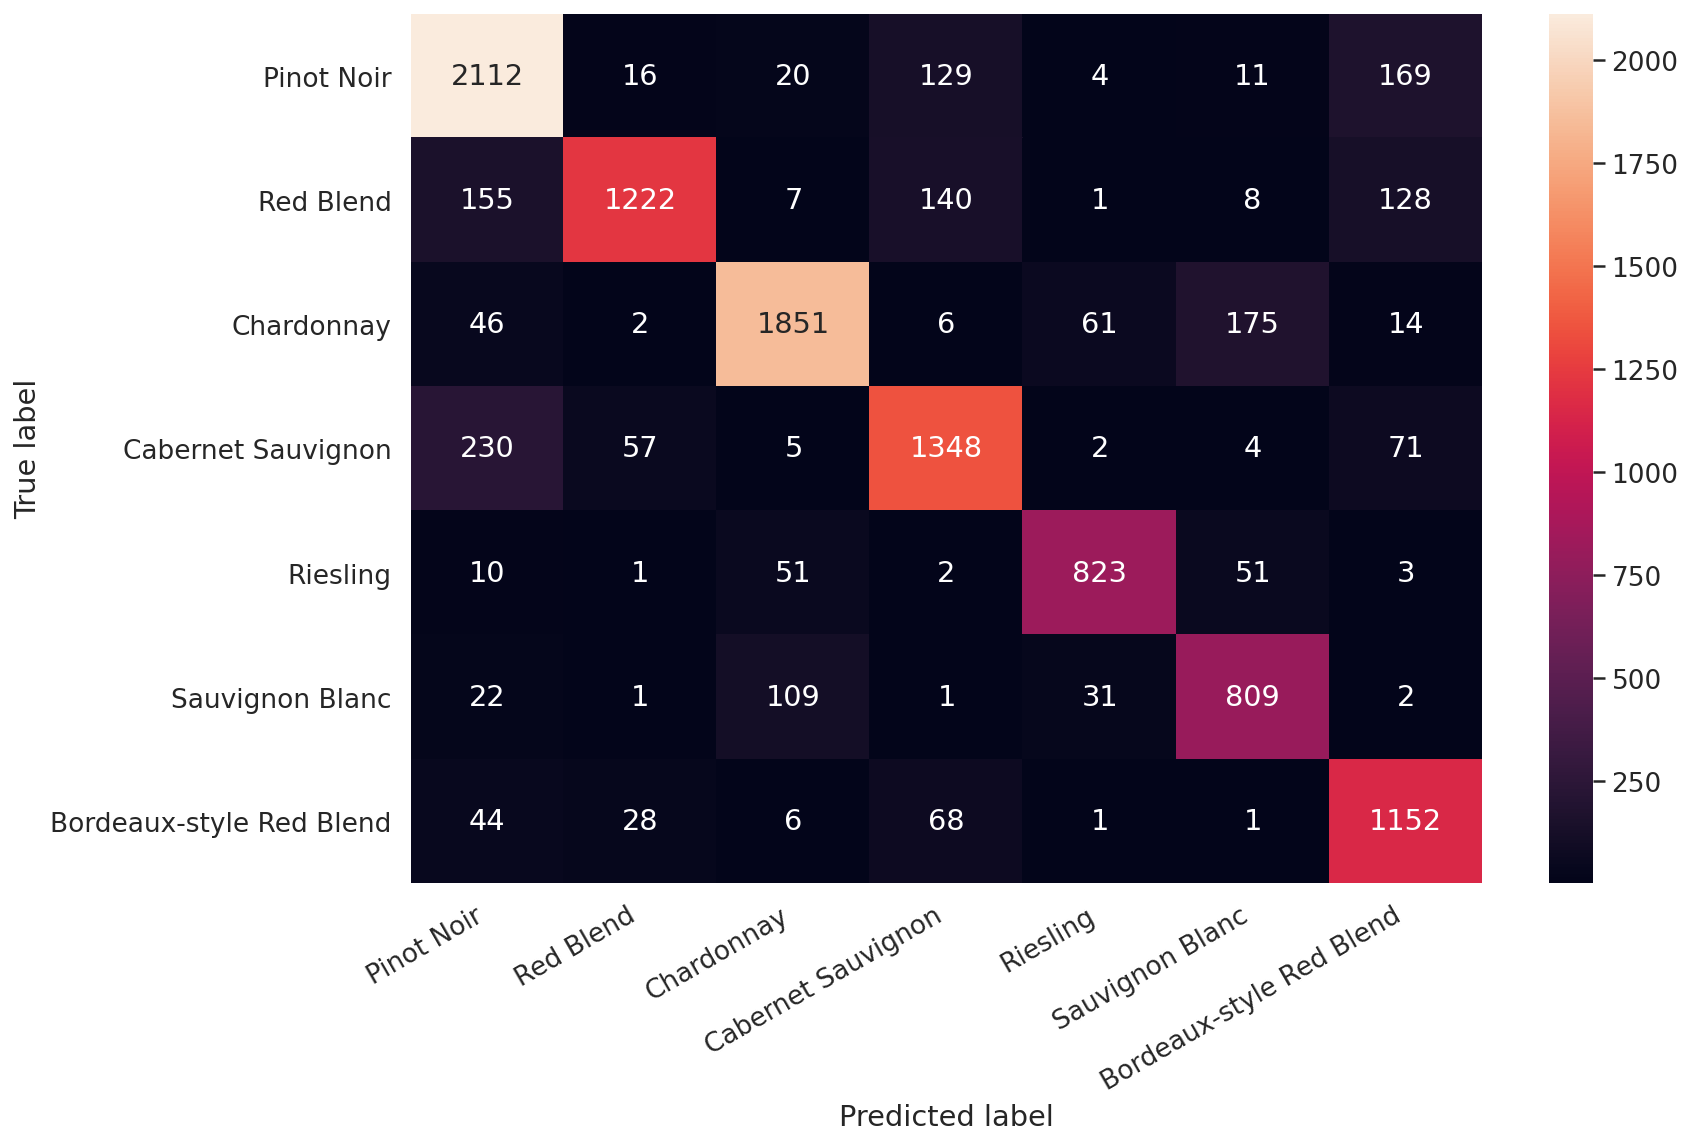

In [67]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [68]:
#Testing
sentences = [
  "Strong wine made of red grapes",
  "Grapy plummy and juicy taste"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
    print("text:", text, "\nintent:", classes[label])
    print()

text: Strong wine made of red grapes 
intent: Pinot Noir

text: Grapy plummy and juicy taste 
intent: Bordeaux-style Red Blend



In [69]:
del model

In [70]:
#2nd case
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5f94bf6590> (prefix:bert_1). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [71]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_3 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 5383

In [72]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [73]:
#Try with different epochs during model training
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history1 = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=10,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
1418/1418 [==============================] - 922s 650ms/step - loss: 1.5813 - acc: 0.5796 - val_loss: 1.3554 - val_acc: 0.8087
Epoch 2/10
1418/1418 [==============================] - 916s 646ms/step - loss: 1.3713 - acc: 0.7944 - val_loss: 1.3401 - val_acc: 0.8250
Epoch 3/10
1418/1418 [==============================] - 918s 648ms/step - loss: 1.3429 - acc: 0.8225 - val_loss: 1.3268 - val_acc: 0.8357
Epoch 4/10
1418/1418 [==============================] - 921s 649ms/step - loss: 1.3295 - acc: 0.8356 - val_loss: 1.3489 - val_acc: 0.8135
Epoch 5/10
1418/1418 [==============================] - 923s 651ms/step - loss: 1.3159 - acc: 0.8487 - val_loss: 1.3155 - val_acc: 0.8492
Epoch 6/10
1418/1418 [==============================] - 925s 653ms/step - loss: 1.3075 - acc: 0.8570 - val_loss: 1.3019 - val_acc: 0.8635
Epoch 7/10
1418/1418 [==============================] - 927s 654ms/step - loss: 1.3005 - acc: 0.8641 - val_loss: 1.3041 - val_acc: 0.8615
Epoch 8/10
1418/1418 [============

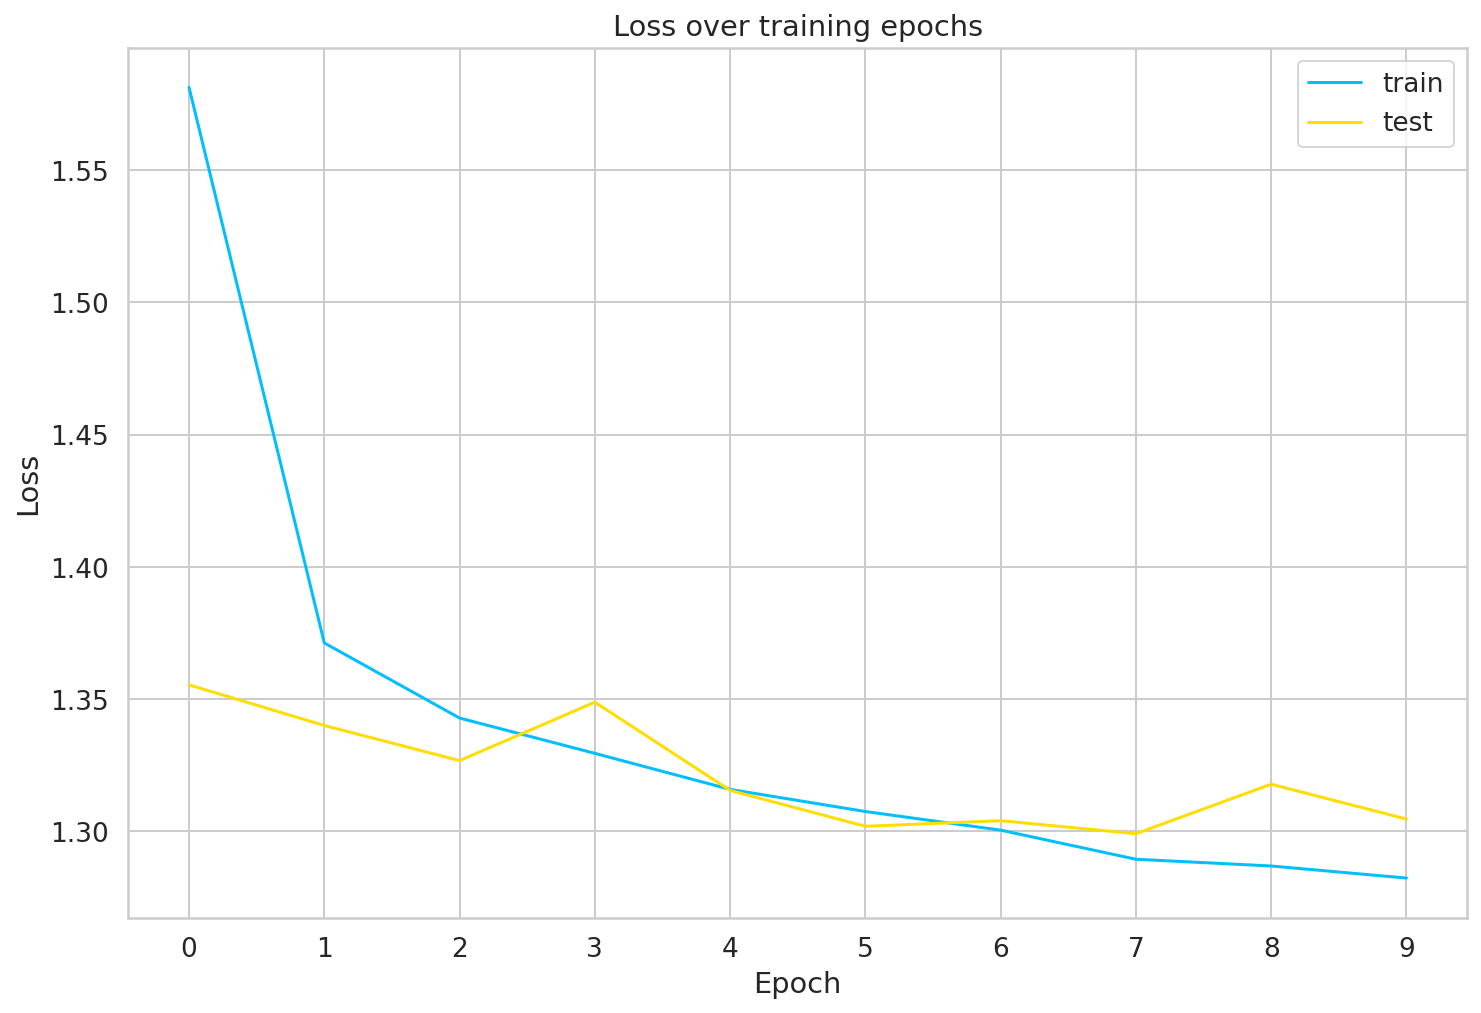

In [74]:
#Loss over training epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history1.history['loss'])
ax.plot(history1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

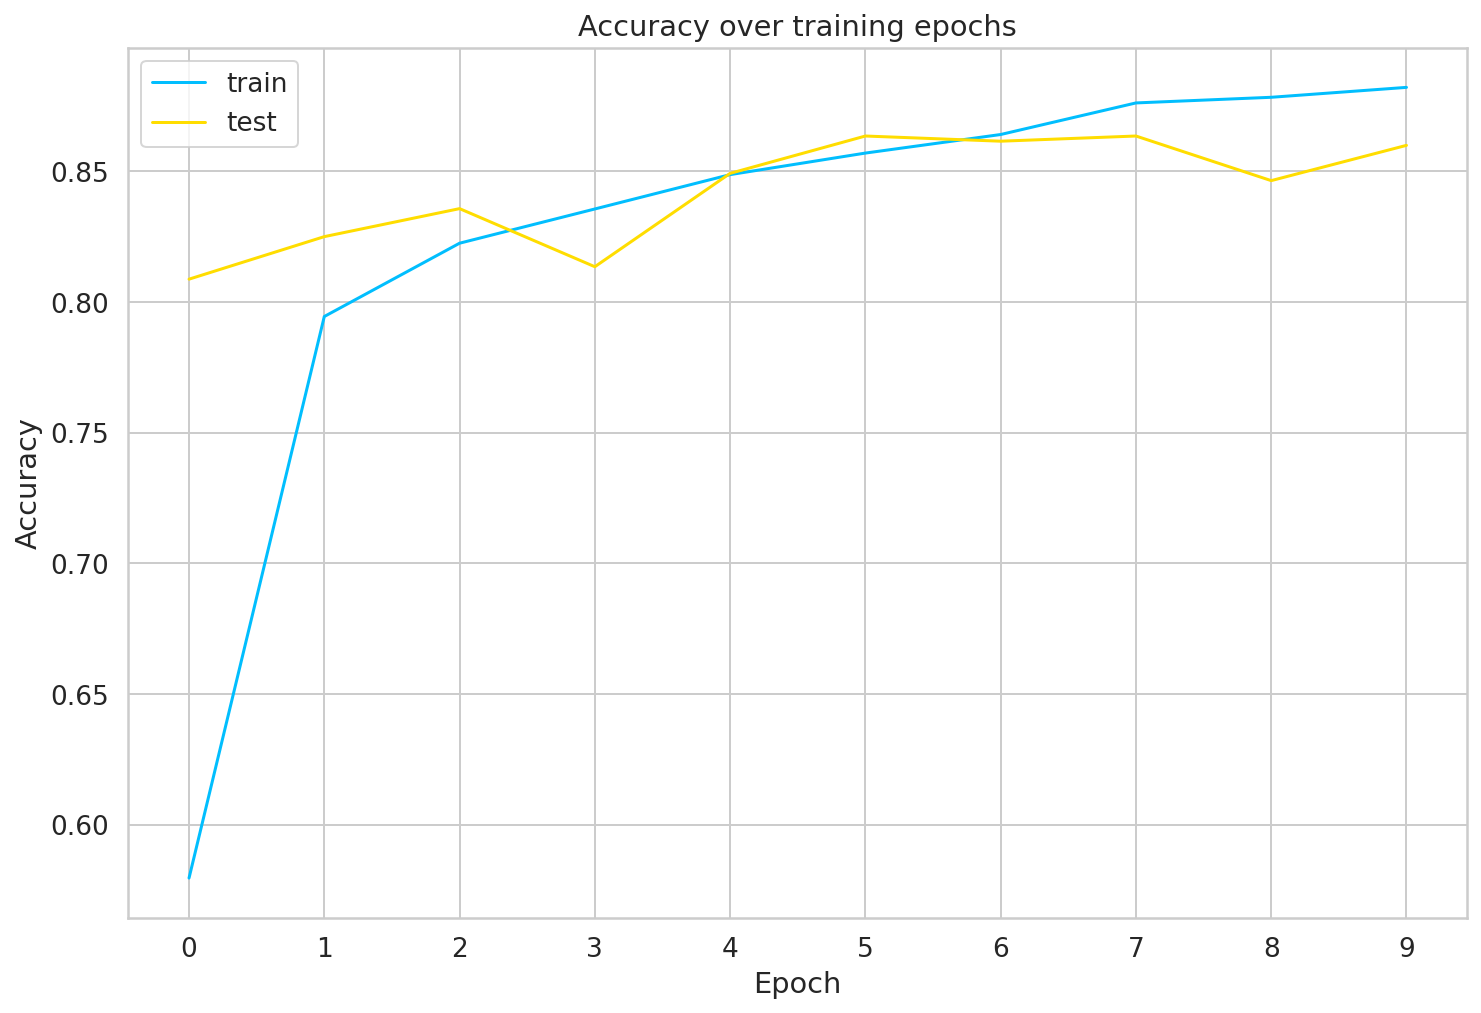

In [75]:
#Accuracy over training epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history1.history['acc'])
ax.plot(history1.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [76]:
#Training and Testing accuracy
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

351/351 [==============================] - 61s 174ms/step - loss: 1.3281 - acc: 0.8365
train acc 0.8948016166687012
test acc 0.8364852666854858


In [77]:
#Classification Report
y_pred = model.predict(data.test_x).argmax(axis=-1)
print(classification_report(data.test_y, y_pred, target_names=classes))

                          precision    recall  f1-score   support

              Pinot Noir       0.88      0.81      0.85      2461
               Red Blend       0.84      0.79      0.82      1661
              Chardonnay       0.88      0.89      0.89      2155
      Cabernet Sauvignon       0.79      0.78      0.78      1717
                Riesling       0.86      0.91      0.88       941
         Sauvignon Blanc       0.82      0.81      0.81       975
Bordeaux-style Red Blend       0.74      0.89      0.81      1300

                accuracy                           0.84     11210
               macro avg       0.83      0.84      0.83     11210
            weighted avg       0.84      0.84      0.84     11210



In [78]:
#Confusion Matrix
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

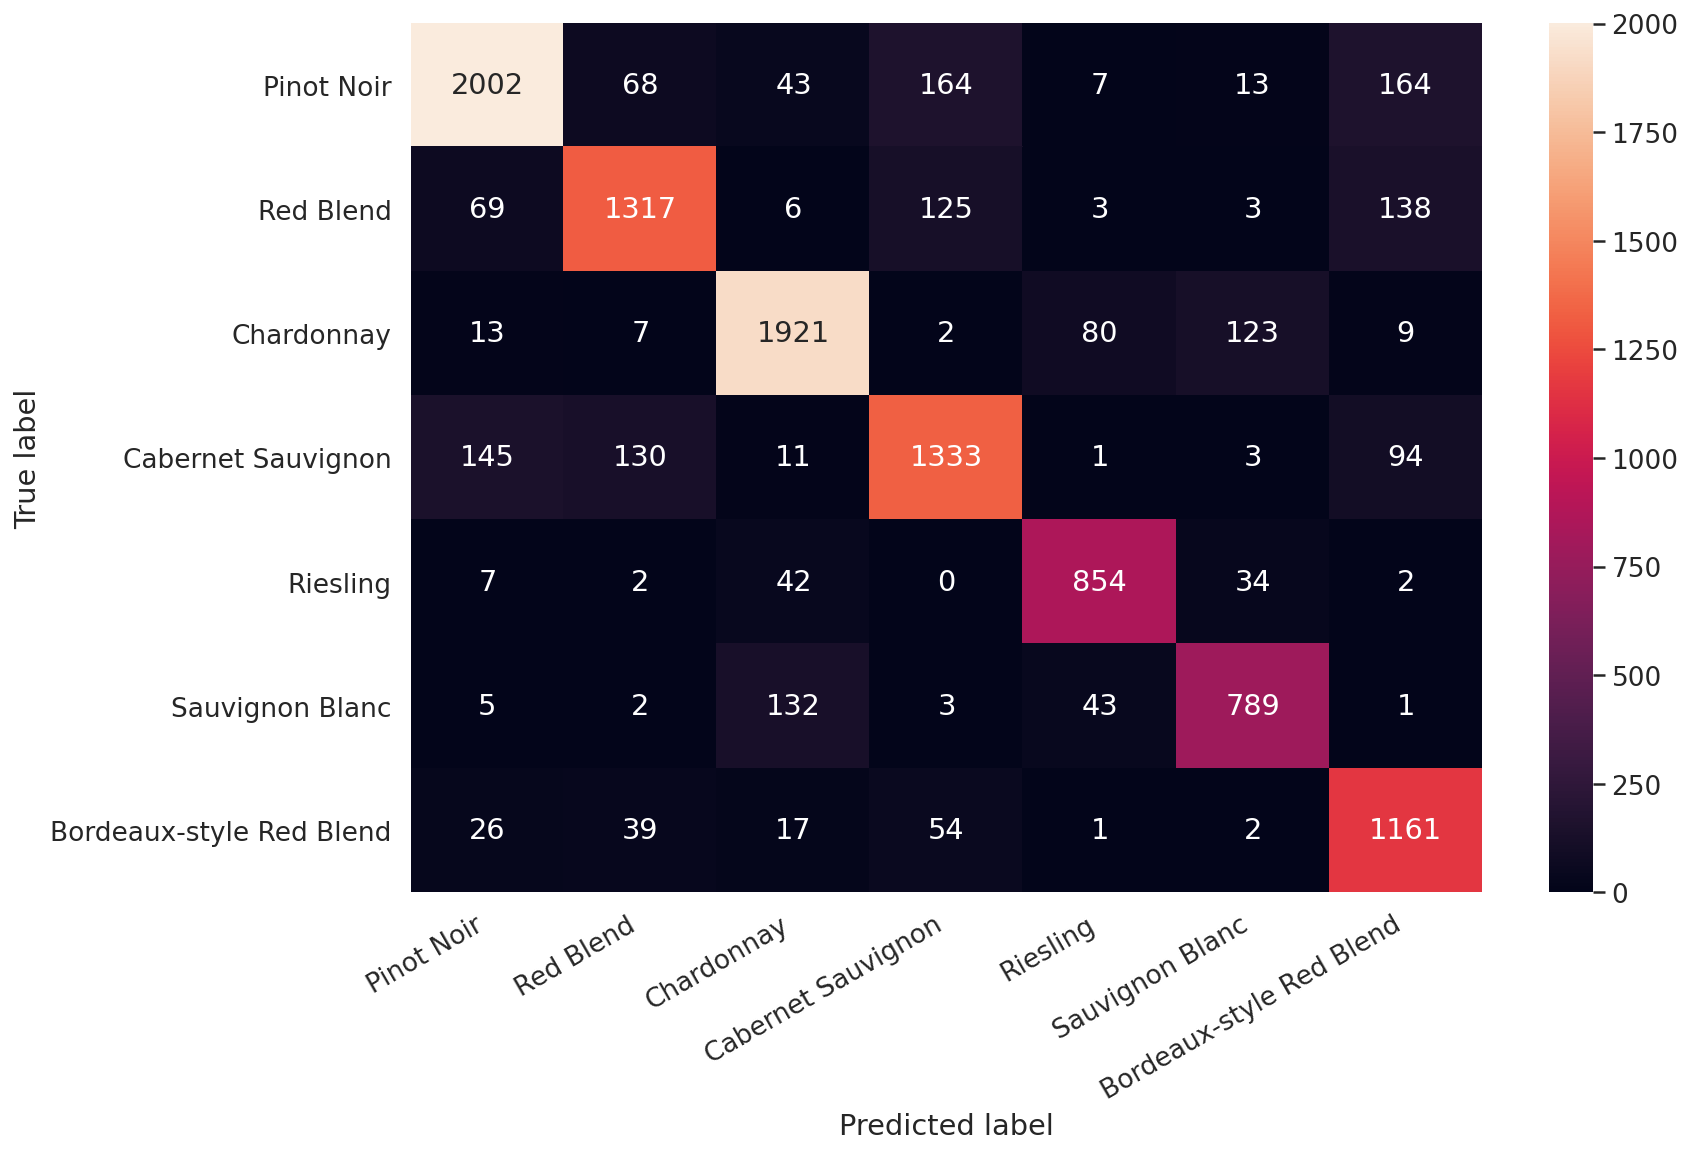

In [79]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [80]:
#Testing
sentences = [
  "Strong wine made of red grapes",
  "Grapy plummy and juicy taste"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
    print("text:", text, "\nintent:", classes[label])
    print()

text: Strong wine made of red grapes 
intent: Red Blend

text: Grapy plummy and juicy taste 
intent: Cabernet Sauvignon



In [81]:
del model

Try with Different Batch Size

In [82]:
#3rd case
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5f5c98d8d0> (prefix:bert_2). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [83]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda_2 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_5 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 5383

In [84]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [85]:
#Changing the batch_size to train the model 
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history2 = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Epoch 1/5
709/709 [==============================] - 624s 880ms/step - loss: 1.7250 - acc: 0.4205 - val_loss: 1.4065 - val_acc: 0.7579
Epoch 2/5
709/709 [==============================] - 623s 878ms/step - loss: 1.3872 - acc: 0.7786 - val_loss: 1.3370 - val_acc: 0.8266
Epoch 3/5
709/709 [==============================] - 620s 874ms/step - loss: 1.3518 - acc: 0.8138 - val_loss: 1.3281 - val_acc: 0.8365
Epoch 4/5
709/709 [==============================] - 623s 879ms/step - loss: 1.3301 - acc: 0.8354 - val_loss: 1.3233 - val_acc: 0.8405
Epoch 5/5
709/709 [==============================] - 620s 875ms/step - loss: 1.3173 - acc: 0.8474 - val_loss: 1.3149 - val_acc: 0.8484


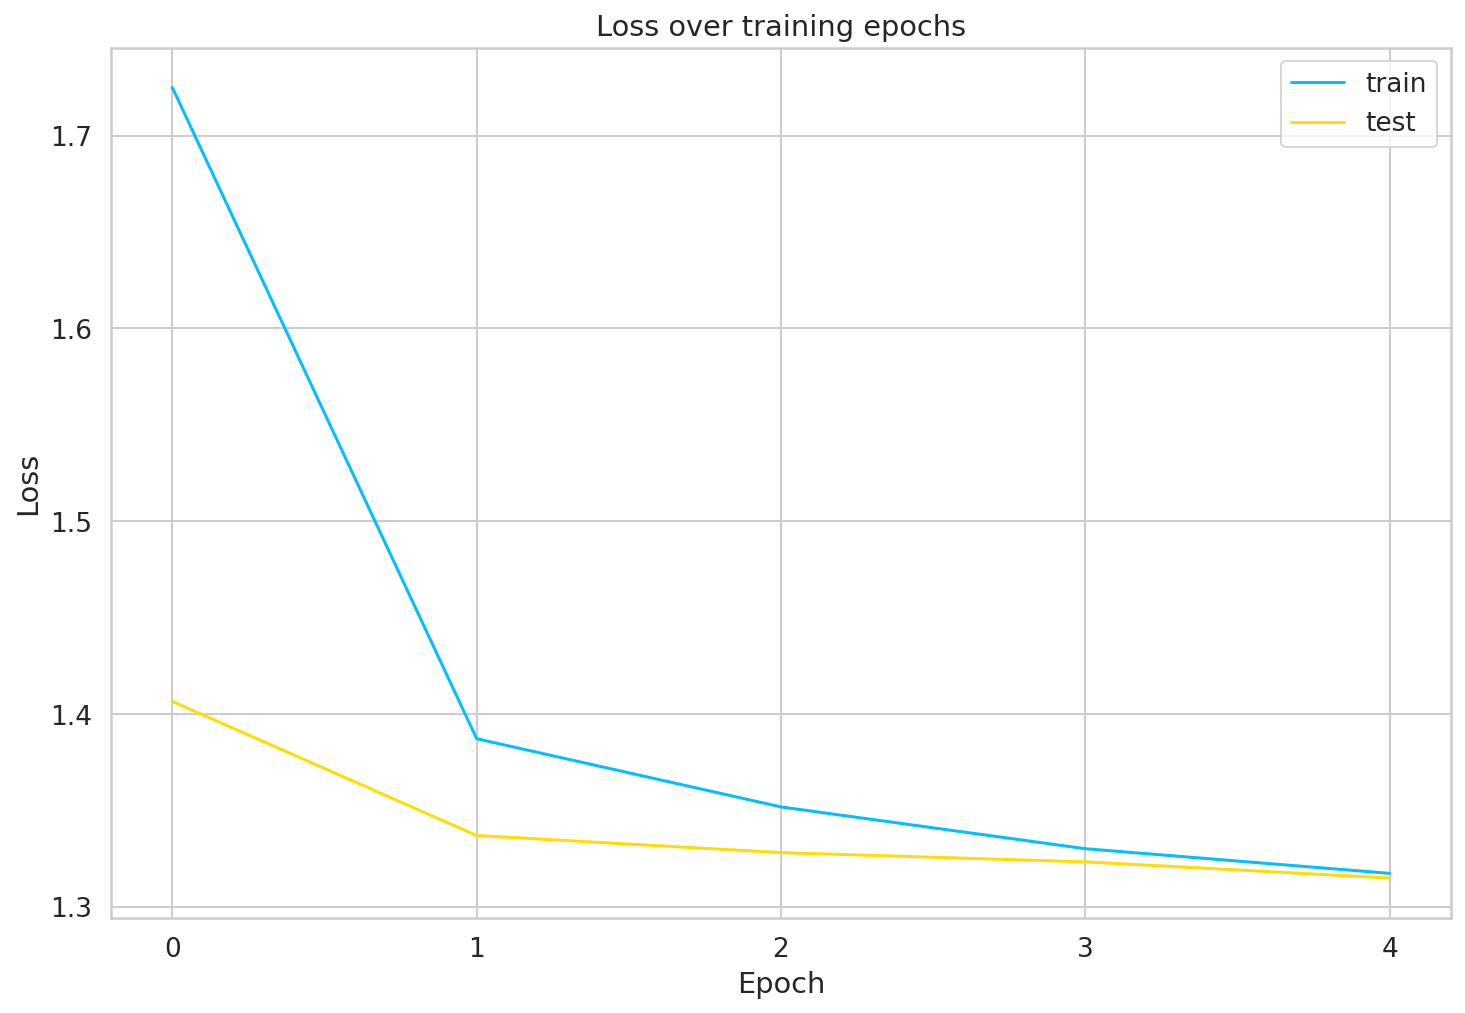

In [86]:
#Loss over training epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history2.history['loss'])
ax.plot(history2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

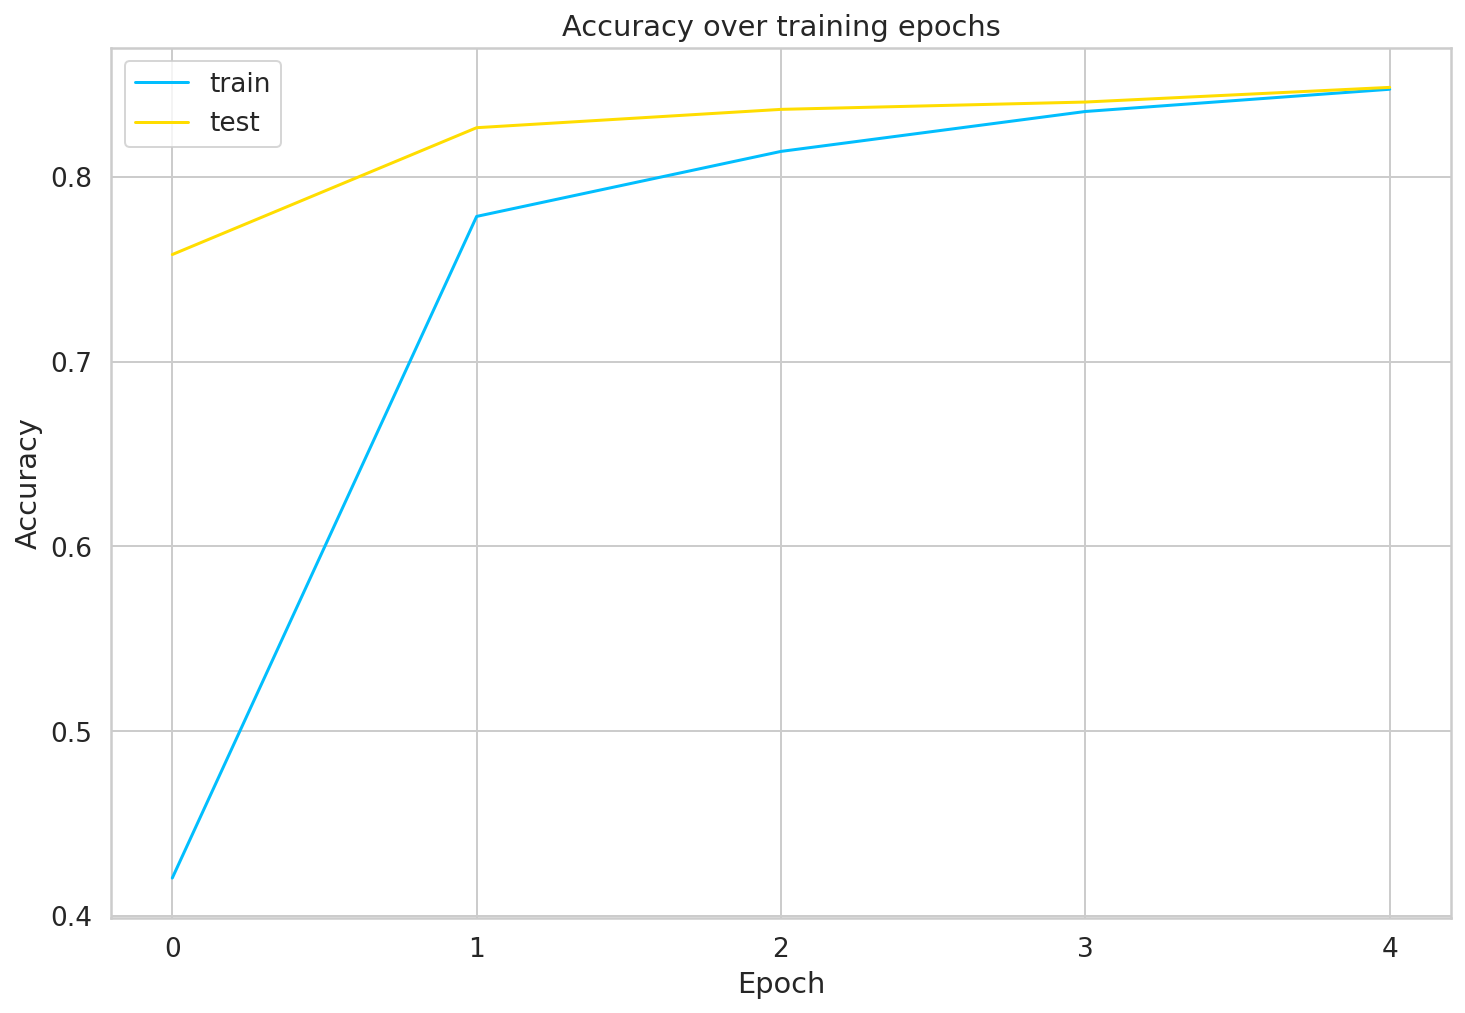

In [87]:
#Accuracy over training epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history2.history['acc'])
ax.plot(history2.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [88]:
#Calculating training accuracy and test accuracy
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

351/351 [==============================] - 61s 174ms/step - loss: 1.3418 - acc: 0.8226
train acc 0.8763889074325562
test acc 0.8225691318511963


In [89]:
#Classification report
y_pred = model.predict(data.test_x).argmax(axis=-1)
print(classification_report(data.test_y, y_pred, target_names=classes))

                          precision    recall  f1-score   support

              Pinot Noir       0.90      0.79      0.84      2461
               Red Blend       0.84      0.79      0.81      1661
              Chardonnay       0.92      0.81      0.86      2155
      Cabernet Sauvignon       0.73      0.83      0.78      1717
                Riesling       0.83      0.92      0.87       941
         Sauvignon Blanc       0.70      0.85      0.77       975
Bordeaux-style Red Blend       0.77      0.85      0.81      1300

                accuracy                           0.82     11210
               macro avg       0.81      0.83      0.82     11210
            weighted avg       0.83      0.82      0.82     11210



In [90]:
#Confusion Matrix
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

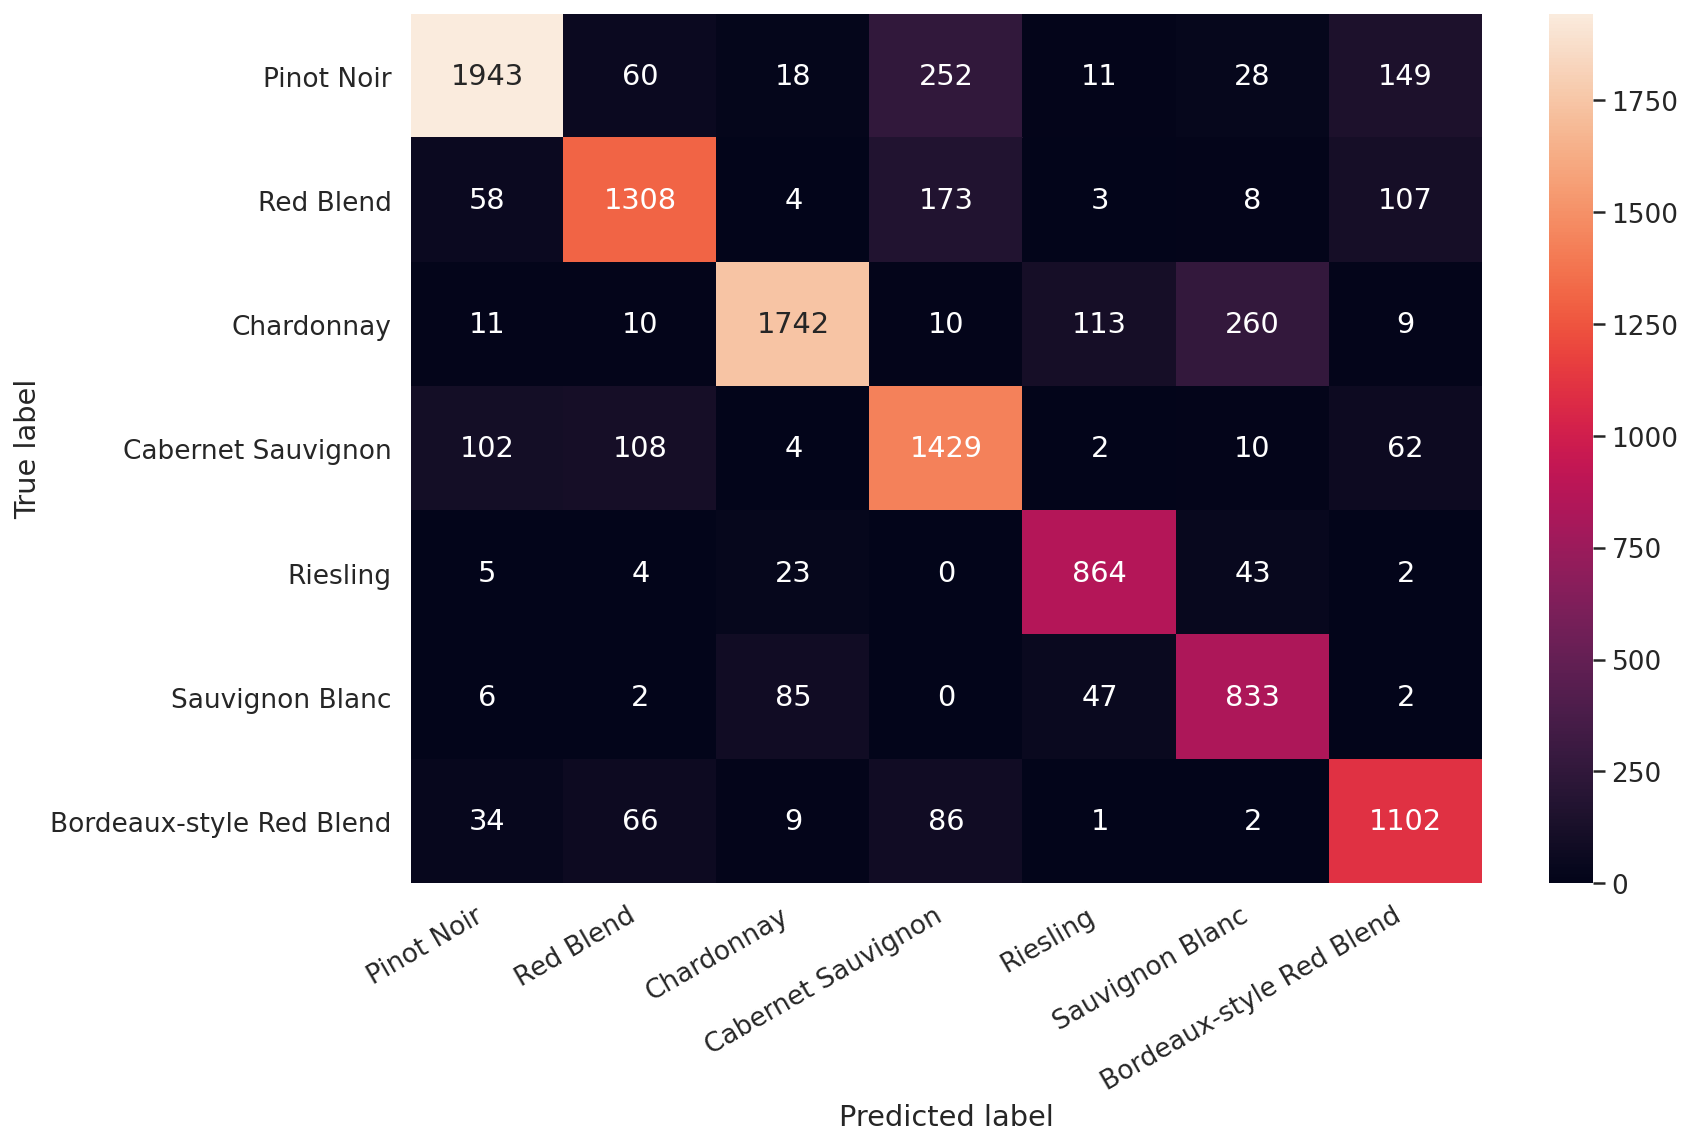

In [91]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [92]:
#Testing
sentences = [
  "Strong wine made of red grapes",
  "Grapy plummy and juicy taste"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
    print("text:", text, "\nintent:", classes[label])
    print()

text: Strong wine made of red grapes 
intent: Pinot Noir

text: Grapy plummy and juicy taste 
intent: Cabernet Sauvignon



In [93]:
del model

In [94]:
#4th case
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 128, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5f48e516d0> (prefix:bert_3). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [95]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda_3 (Lambda)            (None, 768)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 768)               590592    
_________________________________________________________________
dropout_7 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 5383

In [96]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [97]:
#Try with batch size = 32 and epochs = 10
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history3 = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=32,
  shuffle=True,
  epochs=10,
  callbacks=[tensorboard_callback]
)

Epoch 1/10
709/709 [==============================] - 624s 880ms/step - loss: 1.6078 - acc: 0.5586 - val_loss: 1.3517 - val_acc: 0.8143
Epoch 2/10
709/709 [==============================] - 622s 877ms/step - loss: 1.3866 - acc: 0.7818 - val_loss: 1.3387 - val_acc: 0.8266
Epoch 3/10
709/709 [==============================] - 620s 874ms/step - loss: 1.3435 - acc: 0.8221 - val_loss: 1.3231 - val_acc: 0.8405
Epoch 4/10
709/709 [==============================] - 621s 876ms/step - loss: 1.3233 - acc: 0.8426 - val_loss: 1.3231 - val_acc: 0.8417
Epoch 5/10
709/709 [==============================] - 624s 881ms/step - loss: 1.3113 - acc: 0.8540 - val_loss: 1.3164 - val_acc: 0.8484
Epoch 6/10
709/709 [==============================] - 621s 876ms/step - loss: 1.2980 - acc: 0.8672 - val_loss: 1.3103 - val_acc: 0.8548
Epoch 7/10
709/709 [==============================] - 625s 881ms/step - loss: 1.2913 - acc: 0.8739 - val_loss: 1.3283 - val_acc: 0.8357
Epoch 8/10
709/709 [============================

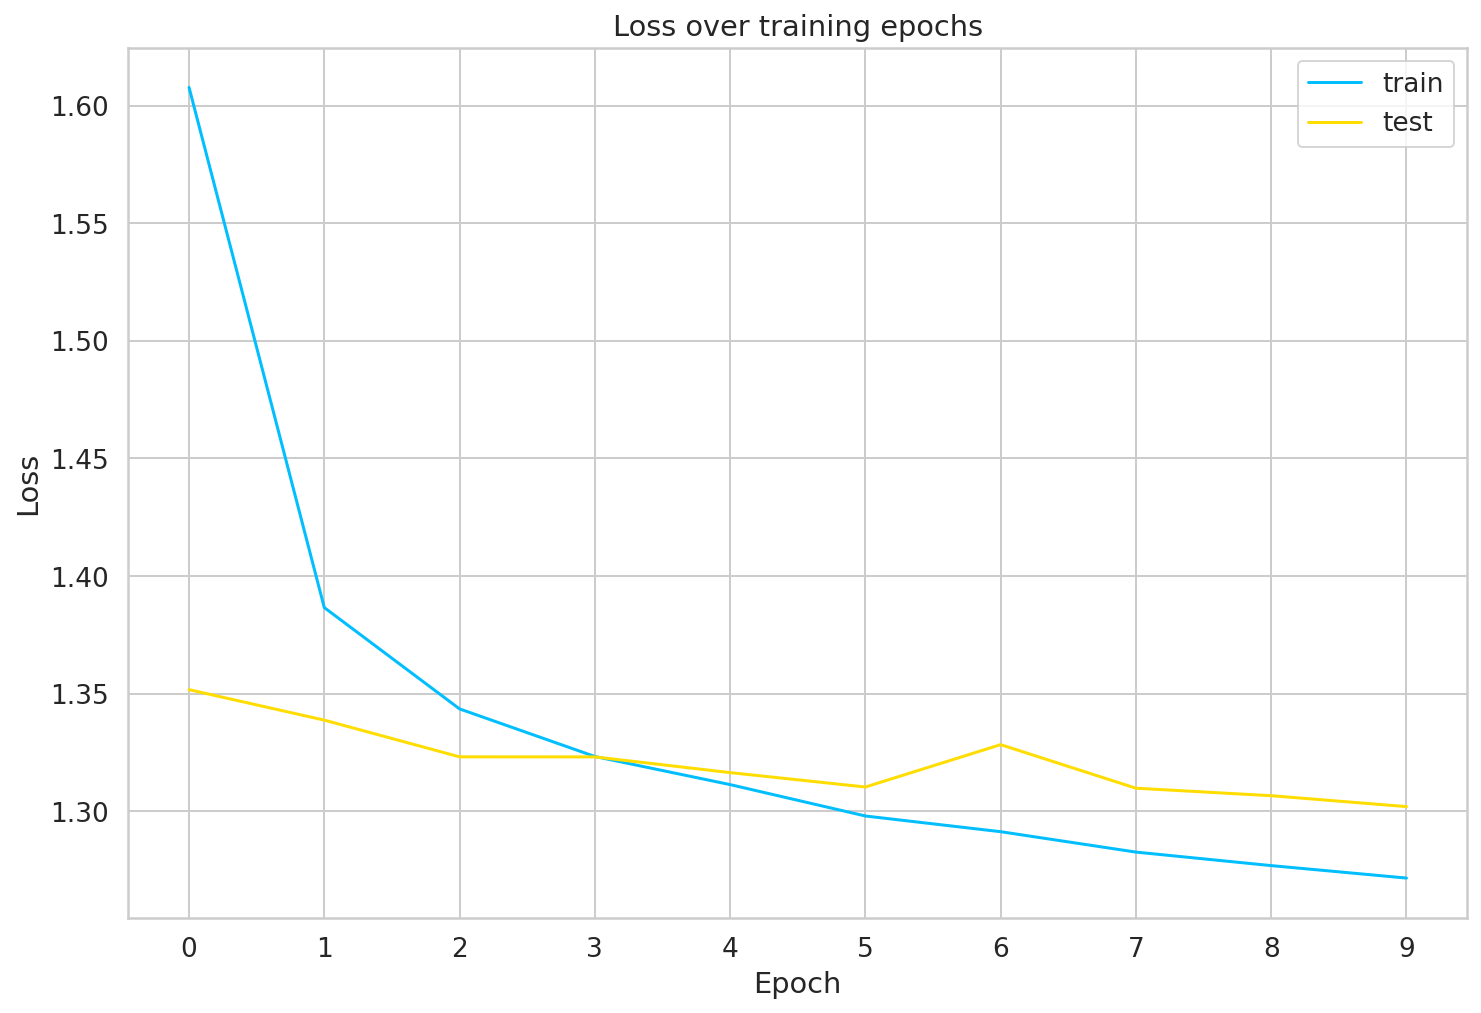

In [98]:
#Loss over training epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history3.history['loss'])
ax.plot(history3.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

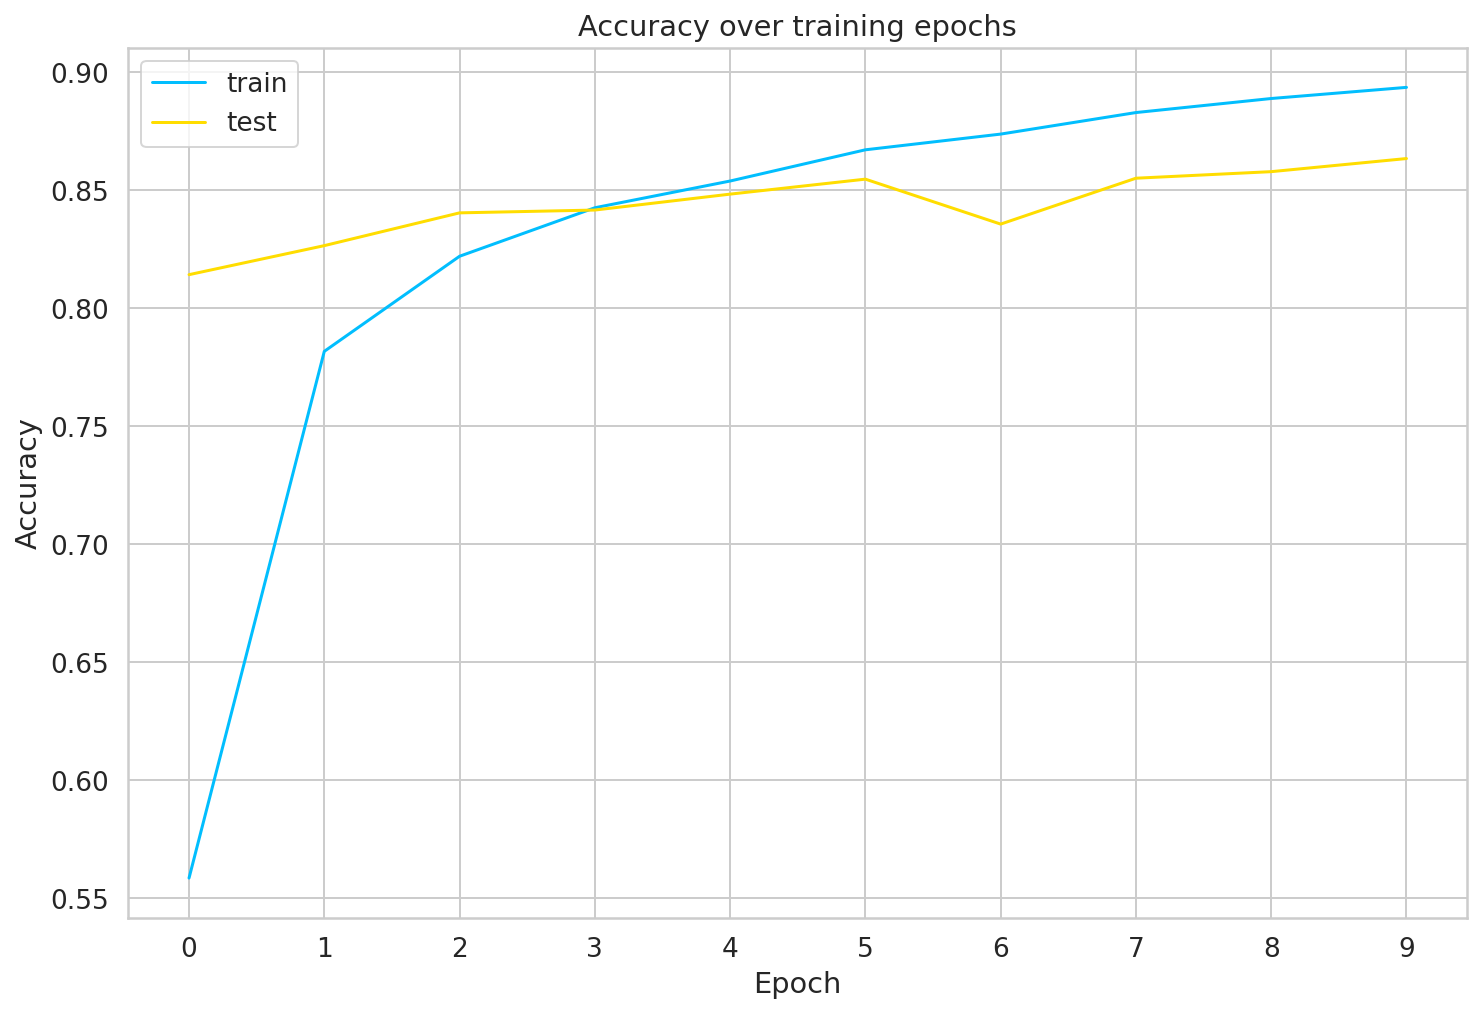

In [99]:
#Accuracy over training epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history3.history['acc'])
ax.plot(history3.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [100]:
#Training and Testing accuracy
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

351/351 [==============================] - 61s 174ms/step - loss: 1.3332 - acc: 0.8301
train acc 0.9077380895614624
test acc 0.8300624489784241


In [101]:
#Classification Report
y_pred = model.predict(data.test_x).argmax(axis=-1)
print(classification_report(data.test_y, y_pred, target_names=classes))

                          precision    recall  f1-score   support

              Pinot Noir       0.90      0.82      0.85      2461
               Red Blend       0.89      0.78      0.83      1661
              Chardonnay       0.94      0.78      0.85      2155
      Cabernet Sauvignon       0.75      0.85      0.80      1717
                Riesling       0.76      0.95      0.84       941
         Sauvignon Blanc       0.72      0.86      0.78       975
Bordeaux-style Red Blend       0.78      0.87      0.82      1300

                accuracy                           0.83     11210
               macro avg       0.82      0.84      0.83     11210
            weighted avg       0.84      0.83      0.83     11210



In [102]:
#Confusion Matrix
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)


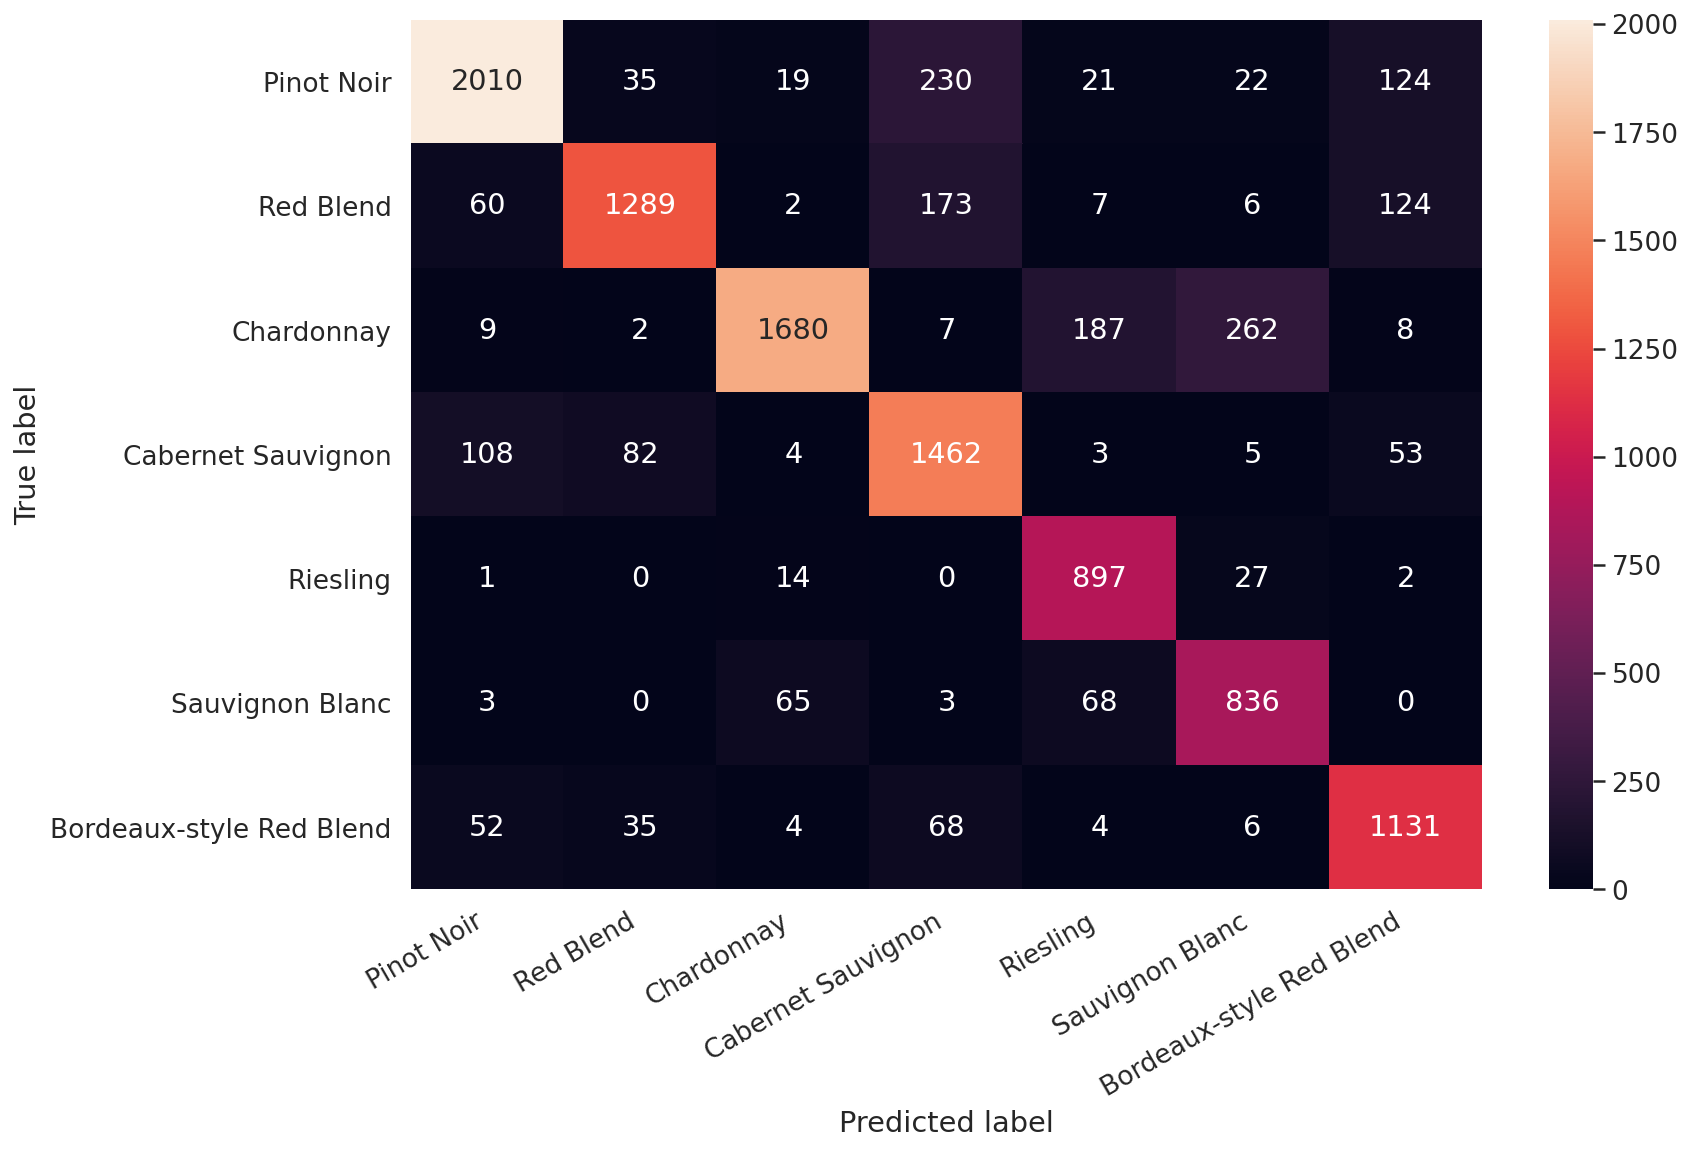

In [103]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# Testing

In [104]:

sentences = [
  "Strong wine made of red grapes",
  "Grapy plummy and juicy taste"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
    print("text:", text, "\nintent:", classes[label])
    print()

text: Strong wine made of red grapes 
intent: Red Blend

text: Grapy plummy and juicy taste 
intent: Cabernet Sauvignon



CONCLUSION:

The presented work demonstrates the successful implementation of a multi-level classification model utilizing
the powerful BERT pre-trained model. The results showcase state-of-the-art performance on a widely recognized
public dataset, with an overall accuracy of 84% achieved through training the model with a batch size of 16 and 10
epochs. The model was trained using a learning rate of 0.00001, Adam optimizer, and a loss function employing sparse
categorical cross entropy. Fine-tuning of the pretrained BERT model was conducting using the wine dataset in four
different configurations: 16 batch size with 5 epochs, 16 batch size with 10 epochs, 32 batch size with 5 epochs,
and 32 batch size with 10 epochs. The best results were obtained when training the model with a batch size of
16 and 10 epochs, demonstrating improved convergence of train and test loss curves and an increased overall accuracy. This model holds significant potential for various applications, particularly in industries such as customer service, where accurate prediction of customer needs and behaviors is vital for success. Overall, this
work establishes a solid foundation for leveraging state-of-the-art natural language processing techniques to
address complex classification problems. 
